In [ ]:
# --- Mount Google Drive and set project paths ---
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

# Base project paths (adjust if your Drive name differs)
base_dir = "/content/drive/MyDrive/Bio_project"
results_dir = os.path.join(base_dir, "results_extension")
dataset_dir = os.path.join(base_dir, "covid_dataset")

# Verify and create directories if missing
os.makedirs(results_dir, exist_ok=True)
os.makedirs(dataset_dir, exist_ok=True)

print("Mounted Drive successfully.")
print("Results directory:", results_dir)
print("Dataset directory:", dataset_dir)


Mounted at /content/drive
Mounted Drive successfully.
Results directory: /content/drive/MyDrive/Bio_project/results_extension
Dataset directory: /content/drive/MyDrive/Bio_project/covid_dataset


In [ ]:
import os

branchA_dir = os.path.join(results_dir, "branchA_dgi")

expected = {
    "kg_graph_extended.gpickle": results_dir,
    "kg_edge_index.npy": results_dir,
    "kg_node_features.npy": results_dir,
    "kg_node_map.json": results_dir,
    "kg_metadata.json": results_dir,
    "kg_node_embeddings_v2.npy": branchA_dir,
    "kg_dgi_model_best.pt": branchA_dir,
}

print("Checking expected files...\n")
for fname, fdir in expected.items():
    fpath = os.path.join(fdir, fname)
    exists = os.path.exists(fpath)
    size = os.path.getsize(fpath)/1024 if exists else 0
    print(f"{'yes' if exists else 'no'} {fname:<30} ({size:.1f} KB) in {fdir}")


Checking expected files...

yes kg_graph_extended.gpickle      (396.1 KB) in /content/drive/MyDrive/Bio_project/results_extension
yes kg_edge_index.npy              (19.0 KB) in /content/drive/MyDrive/Bio_project/results_extension
yes kg_node_features.npy           (34.0 KB) in /content/drive/MyDrive/Bio_project/results_extension
yes kg_node_map.json               (18.3 KB) in /content/drive/MyDrive/Bio_project/results_extension
yes kg_metadata.json               (0.2 KB) in /content/drive/MyDrive/Bio_project/results_extension
yes kg_node_embeddings_v2.npy      (217.1 KB) in /content/drive/MyDrive/Bio_project/results_extension/branchA_dgi
yes kg_dgi_model_best.pt           (140.8 KB) in /content/drive/MyDrive/Bio_project/results_extension/branchA_dgi


In [ ]:
import os
import pandas as pd

# --- Paths ---
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results_extension")
nextclade_csv = os.path.join(results_dir, "nextclade.csv")
assert os.path.exists(nextclade_csv), f"Nextclade file not found: {nextclade_csv}"

print(f"Reading modern Nextclade output: {nextclade_csv}")

# --- Load using correct delimiter ---
df = pd.read_csv(nextclade_csv, sep=";", encoding="utf-8", engine="python")
print(f"Loaded: {df.shape[0]} rows × {df.shape[1]} cols")
print("Columns:", list(df.columns)[:20])

# --- Step 1: Detect columns ---
seq_col = None
for c in ["seqName", "Sample", "Name", "seq_id"]:
    if c in df.columns:
        seq_col = c
        break

# Updated modern Nextclade AA columns
aa_cols = [c for c in ["aaSubstitutions", "aaDeletions", "aaInsertions"] if c in df.columns]
if not seq_col or not aa_cols:
    raise ValueError(f"Could not find sequence or AA mutation columns. Found columns: {list(df.columns)}")

print("Using sequence column:", seq_col, "| AA columns:", aa_cols)

# --- Step 2: Expand amino acid mutations ---
records = []
for _, row in df.iterrows():
    seq = str(row[seq_col])
    for col in aa_cols:
        cell = str(row[col])
        if cell.strip() in ["", "nan", "NA"]:
            continue
        for ch in cell.split(","):
            ch = ch.strip()
            if not ch:
                continue
            if ":" in ch:
                gene, aa_change = ch.split(":", 1)
            else:
                gene, aa_change = "Unknown", ch
            mut_type = (
                "deletion" if "del" in aa_change.lower() or col.lower().endswith("deletions")
                else "insertion" if col.lower().endswith("insertions")
                else "substitution"
            )
            records.append({
                "variant": seq,
                "gene": gene,
                "aa_change": aa_change,
                "type": mut_type
            })

# --- Step 3: Save the expanded mutation table ---
mut_aa_df = pd.DataFrame(records)
out_path = os.path.join(results_dir, "mutations_aa.csv")
mut_aa_df.to_csv(out_path, index=False, encoding="utf-8")

print(f"\nSaved expanded mutation table → {out_path}")
print("Variants:", mut_aa_df['variant'].nunique())
print("Genes:", mut_aa_df['gene'].nunique())
print("Unique AA changes:", mut_aa_df['aa_change'].nunique())
print("Total records:", len(mut_aa_df))


Reading modern Nextclade output: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\nextclade.csv
Loaded: 25 rows × 102 cols
Columns: ['index', 'seqName', 'clade', 'clade_display', 'clade_who', 'clade_nextstrain', 'partiallyAliased', 'Nextclade_pango', 'qc.overallScore', 'qc.overallStatus', 'totalSubstitutions', 'totalDeletions', 'totalInsertions', 'totalFrameShifts', 'totalMissing', 'totalNonACGTNs', 'totalAminoacidSubstitutions', 'totalAminoacidDeletions', 'totalAminoacidInsertions', 'totalUnknownAa']
Using sequence column: seqName | AA columns: ['aaSubstitutions', 'aaDeletions', 'aaInsertions']

Saved expanded mutation table → f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\mutations_aa.csv
Variants: 23
Genes: 12
Unique AA changes: 303
Total records: 877


In [ ]:
# Normalize variant IDs (remove descriptions, keep accession only)
import re

clean_variants = []
for v in variants_union:
    v = str(v).split()[0].strip().replace(",", "")
    v = re.sub(r"\.1$", "", v)  # remove version suffix if duplicate exists
    clean_variants.append(v)

variants_union = sorted(set(clean_variants))
print(f"Cleaned variant count = {len(variants_union)}")


Cleaned variant count = 33


In [ ]:
# ====================================================
# Cell 2 — Build Node Lists (with Proper Variant Cleanup)
# ====================================================

import os, re
from pathlib import Path
import pandas as pd
from Bio import SeqIO

# --- Base paths ---
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results_extension")  # use new results folder
covid_dir = os.path.join(base_dir, "covid_dataset")

# --- Load input CSVs ---
mut_aa_path = os.path.join(results_dir, "mutations_aa.csv")
mut_vcf_path = os.path.join(results_dir, "mutations_from_alignment_vcf.csv")
nextclade_path = os.path.join(results_dir, "nextclade.csv")

mut_aa = pd.read_csv(mut_aa_path) if os.path.exists(mut_aa_path) else pd.DataFrame()
mut_vcf = pd.read_csv(mut_vcf_path) if os.path.exists(mut_vcf_path) else pd.DataFrame()
nextclade = pd.read_csv(nextclade_path, sep=";", engine="python") if os.path.exists(nextclade_path) else pd.DataFrame()

# --- Variant sources ---
variants_from_mutaa = set(mut_aa["variant"].astype(str).unique()) if "variant" in mut_aa.columns else set()
variants_from_mutvcf = set(mut_vcf["sample"].astype(str).unique()) if "sample" in mut_vcf.columns else set()
variants_from_nextclade = set()
for c in ["seqName", "Sample", "Name", "seq_id"]:
    if c in nextclade.columns:
        variants_from_nextclade = set(nextclade[c].astype(str).str.split().str[0].unique())
        break

# --- Variants from GenBank filenames ---
gb_files = [f for f in os.listdir(covid_dir) if f.endswith(".gb")]
variants_from_gb = set([os.path.splitext(f)[0] for f in gb_files])

# --- Union of all variant IDs ---
variants_union = list(variants_from_mutaa | variants_from_mutvcf | variants_from_nextclade | variants_from_gb)

# --- Normalize variant IDs ---
clean_variants = []
for v in variants_union:
    v = str(v).split()[0].strip().replace(",", "")
    v = re.sub(r"\.1$", "", v)  # remove version suffix if duplicate exists
    clean_variants.append(v)

variants_union = sorted(set(clean_variants))

# --- Mutation list ---
if not mut_aa.empty and "aa_change" in mut_aa.columns:
    if "mut_name" not in mut_aa.columns:
        mut_aa["mut_name"] = mut_aa.apply(
            lambda r: f"{r['gene']}:{r['aa_change']}" if pd.notna(r.get("gene")) else r["aa_change"], axis=1
        )
    mutations = sorted(mut_aa["mut_name"].dropna().unique().tolist())
elif not mut_vcf.empty and {"pos", "ref", "alt"}.issubset(mut_vcf.columns):
    mutations = sorted((mut_vcf["pos"].astype(str) + ":" + mut_vcf["ref"] + ">" + mut_vcf["alt"]).unique().tolist())
else:
    mutations = []

# --- Genes from mutations + GenBank ---
genes_from_mutaa = set(mut_aa["gene"].dropna().unique().tolist()) if "gene" in mut_aa.columns else set()
genes_from_gb = set()
for gb_file in gb_files:
    try:
        rec = SeqIO.read(os.path.join(covid_dir, gb_file), "genbank")
        for feat in rec.features:
            if feat.type == "CDS":
                name = feat.qualifiers.get("gene", feat.qualifiers.get("product", ["unknown"]))[0]
                genes_from_gb.add(name)
    except Exception as e:
        print(f"Warning: could not parse {gb_file}: {e}")

genes_union = sorted(genes_from_mutaa | genes_from_gb)

# --- Lineages from modern Nextclade fields ---
lineage_cols = [c for c in ["Nextclade_pango", "pango", "Pango_Lineage_NC", "Pango_Lineage_Pangolin", "clade_nextstrain"] if c in nextclade.columns]
lineages = set()
for c in lineage_cols:
    lineages |= set(nextclade[c].dropna().unique().tolist())
lineages = sorted(lineages)

# --- Diagnostics summary ---
print("Sources counts:")
print(" - variants in mut_aa:", len(variants_from_mutaa))
print(" - variants in mut_vcf:", len(variants_from_mutvcf))
print(" - variants in nextclade:", len(variants_from_nextclade))
print(" - gb files found:", len(gb_files))
print("Unified counts:")
print(f"Cleaned Variants (union) = {len(variants_union)}")
print(f"Mutations = {len(mutations)}")
print(f"Genes = {len(genes_union)}")
print(f"Lineages = {len(lineages)}")
print()
print("Example variant IDs (first 30):", variants_union[:30])

# --- Save cleaned variant list ---
pd.DataFrame({"variant_id": variants_union}).to_csv(os.path.join(results_dir, "variant_list.csv"), index=False)
print(f"Saved {os.path.join(results_dir, 'variant_list.csv')}")

# Assign to globals for downstream KG building
variants = variants_union
genes = genes_union


Sources counts:
 - variants in mut_aa: 23
 - variants in mut_vcf: 0
 - variants in nextclade: 25
 - gb files found: 32
Unified counts:
Cleaned Variants (union) = 33
Mutations = 304
Genes = 22
Lineages = 35

Example variant IDs (first 30): ['MN908947.3', 'MN985325', 'MW301120', 'MW301121', 'MW301245', 'MW301247', 'MW420785', 'MW633280', 'MW729262', 'MW729265', 'MZ054073', 'MZ054074', 'MZ169910', 'MZ169911', 'MZ571142', 'NC_045512.2', 'OK091006', 'OL965487', 'OL965902', 'OM287553', 'ON123456', 'ON456789', 'ON982782', 'OP012345', 'OP293520', 'OP684305', 'OR782922', 'OR789768', 'OR958377', 'OR998518']
Saved f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\variant_list.csv


In [ ]:
# --- Cell 3: Create Node & Edge DataFrames (Extended Version) ---
nodes = []

results_ext_dir = os.path.join(base_dir, "results_extension")


for v in variants:
    nodes.append({
        "node_id": f"VARIANT|{v}",
        "node_type": "Variant",
        "label": v
    })

for m in mutations:
    nodes.append({
        "node_id": f"MUTATION|{m}",
        "node_type": "Mutation",
        "label": m
    })

for g in genes:
    nodes.append({
        "node_id": f"GENE|{g}",
        "node_type": "Gene",
        "label": g
    })

if 'pango' in nextclade.columns:
    lineages = nextclade['pango'].dropna().unique().tolist()
if 'clade' in nextclade.columns:
    clades = nextclade['clade'].dropna().unique().tolist()
else:
    clades = []

for l in lineages:
    nodes.append({
        "node_id": f"LINEAGE|{l}",
        "node_type": "Lineage",
        "label": l
    })

for c in clades:
    nodes.append({
        "node_id": f"CLADE|{c}",
        "node_type": "Clade",
        "label": c
    })

nodes_df = pd.DataFrame(nodes).drop_duplicates(subset=["node_id"])
nodes_df.to_csv(os.path.join(results_ext_dir, "kg_nodes.csv"), index=False)
print(f"Nodes saved: {len(nodes_df)}")

# -------------------------------------------------------------------------
# --- Edges ---
edges = []

if not mut_aa.empty:
    for _, r in mut_aa.iterrows():
        v, m, g = r.get("variant"), r.get("mut_name"), r.get("gene")
        if pd.notna(v) and pd.notna(m):
            edges.append({"source": f"VARIANT|{v}", "target": f"MUTATION|{m}", "etype": "HAS_MUTATION"})
        if pd.notna(m) and pd.notna(g):
            edges.append({"source": f"MUTATION|{m}", "target": f"GENE|{g}", "etype": "IN_GENE"})

if not nextclade.empty:
    for _, r in nextclade.iterrows():
        sample = str(r.get("seqName") or r.get("Sample") or "").strip()
        lineage = r.get("pango") or r.get("Pango_Lineage_NC") or r.get("Pango_Lineage_Pangolin")
        clade = r.get("clade") or r.get("Nextclade_Clade") or r.get("nextstrainClade")
        qc = r.get("qc_status") or r.get("QC_Status")

        if sample and lineage:
            edges.append({"source": f"VARIANT|{sample}", "target": f"LINEAGE|{lineage}", "etype": "BELONGS_TO"})
        if sample and clade:
            edges.append({"source": f"VARIANT|{sample}", "target": f"CLADE|{clade}", "etype": "HAS_CLADE"})
        if qc:
            edges.append({"source": f"VARIANT|{sample}", "target": f"QC|{qc}", "etype": "HAS_QC"})

edges_df = pd.DataFrame(edges).drop_duplicates().reset_index(drop=True)
edges_df.to_csv(os.path.join(results_ext_dir, "kg_edges.csv"), index=False)
print(f"Edges saved: {len(edges_df)}")


Nodes saved: 409
Edges saved: 1206


In [ ]:
# ====================================================
# Cell 4 — Build Extended Knowledge Graph (NetworkX) + Save in Both Formats
# ====================================================

import os
import pickle
import networkx as nx
from Bio import SeqIO

# --- Create Graph ---
G = nx.DiGraph()

# Add nodes with safe defaults
for _, r in nodes_df.iterrows():
    G.add_node(
        r.get("node_id", f"NODE_{_}"),
        node_type=r.get("node_type", "Unknown"),
        label=r.get("label", f"NODE_{_}")
    )

# Add edges safely
for _, r in edges_df.iterrows():
    src, tgt, etype = r.get("source"), r.get("target"), r.get("etype", "Unknown")
    if pd.notna(src) and pd.notna(tgt):
        G.add_edge(src, tgt, etype=etype)

# ====================================================
# --- Enrich Biological Attributes ---
# ====================================================

# Compute gene lengths from all GenBank files
gene_lengths = {}
for gb_file in os.listdir(covid_dir):
    if gb_file.endswith(".gb"):
        gb_path = os.path.join(covid_dir, gb_file)
        try:
            gb = SeqIO.read(gb_path, "genbank")
            for feat in gb.features:
                if feat.type == "CDS":
                    gene = feat.qualifiers.get("gene", ["unknown"])[0]
                    length = int((feat.location.end - feat.location.start) / 3)
                    gene_lengths[gene] = max(gene_lengths.get(gene, 0), length)
        except Exception as e:
            print(f"Warning: Failed to parse {gb_file}: {e}")

print(f"Computed average lengths for {len(gene_lengths)} genes from {len(os.listdir(covid_dir))} genomes.")

# Mutation frequency and variant mutation count
mut_freq = mut_aa.groupby("mut_name").size().to_dict() if not mut_aa.empty else {}
var_mut_ct = mut_aa.groupby("variant").size().to_dict() if not mut_aa.empty else {}

# ====================================================
# --- Add Node Attributes ---
# ====================================================

for node in G.nodes:
    attrs = G.nodes[node]
    label = attrs.get("label", node)
    ntype = attrs.get("node_type", "Unknown")

    if ntype == "Mutation":
        attrs["mutation_freq"] = mut_freq.get(label, 0)

    elif ntype == "Gene":
        attrs["gene_length"] = gene_lengths.get(label, 0)

    elif ntype == "Variant":
        attrs["variant_mut_count"] = var_mut_ct.get(label, 0)

        # --- Add lineage / clade / QC info from Nextclade ---
        if not nextclade.empty:
            sample_col = None
            for c in ["seqName", "Sample", "Name", "seq_id"]:
                if c in nextclade.columns:
                    sample_col = c
                    break

            if sample_col:
                row = nextclade[nextclade[sample_col].astype(str).str.contains(label, na=False)]
                if not row.empty:
                    # Add lineage/pango
                    for col in ["Nextclade_pango", "pango", "Pango_Lineage_NC", "Pango_Lineage_Pangolin"]:
                        if col in row.columns and pd.notna(row.iloc[0][col]):
                            attrs["pango"] = row.iloc[0][col]
                            break
                    # Add clade
                    for col in ["clade", "clade_nextstrain", "Nextclade_Clade"]:
                        if col in row.columns and pd.notna(row.iloc[0][col]):
                            attrs["clade"] = row.iloc[0][col]
                            break
                    # Add QC status
                    for col in ["qc.overallStatus", "QC_Status", "qc_status"]:
                        if col in row.columns and pd.notna(row.iloc[0][col]):
                            attrs["qc_status"] = row.iloc[0][col]
                            break

# ====================================================
# --- Save Graphs ---
# ====================================================

results_ext_dir = os.path.join(base_dir, "results_extension")
os.makedirs(results_ext_dir, exist_ok=True)

gpath_gpickle = os.path.join(results_ext_dir, "kg_graph_extended.gpickle")
gpath_gexf = os.path.join(results_ext_dir, "kg_graph_extended.gexf")

# Save binary format (for ML/GNN)
with open(gpath_gpickle, "wb") as f:
    pickle.dump(G, f)

# Save XML format (for visualization tools)
nx.write_gexf(G, gpath_gexf)

# ====================================================
# --- Summary ---
# ====================================================

node_types = set(nx.get_node_attributes(G, "node_type").values())
print("\nKnowledge Graph (Extended) built successfully.")
print(f"  Internal ML format (pickle): {gpath_gpickle}")
print(f"  Visualization format (GEXF): {gpath_gexf}")
print(f"Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}")
print(f"Node types: {node_types}")

# Breakdown by node type
type_counts = {t: sum(1 for _, d in G.nodes(data=True) if d.get("node_type") == t) for t in node_types}
print("Node type counts:", type_counts)


Computed average lengths for 19 genes from 40 genomes.

Knowledge Graph (Extended) built successfully.
  Internal ML format (pickle): f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_graph_extended.gpickle
  Visualization format (GEXF): f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_graph_extended.gexf
Nodes: 434 | Edges: 1206
Node types: {'Variant', 'Clade', 'Lineage', 'Mutation', 'Gene'}
Node type counts: {'Variant': 33, 'Clade': 15, 'Lineage': 35, 'Mutation': 304, 'Gene': 22}


Graph loaded successfully from f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_graph_extended.gpickle
Nodes: 434 | Edges: 1206
Node type distribution: Counter({'Mutation': 304, 'Variant': 58, 'Lineage': 35, 'Gene': 22, 'Clade': 15})
Edge type distribution: Counter({'HAS_MUTATION': 877, 'IN_GENE': 304, 'HAS_CLADE': 25})
Average degree: 5.56
Max degree node: GENE|S → 128

Top 10 nodes by degree:
GENE|S                                             | Type=Gene       | Degree=128
VARIANT|PP485688.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/CO-CDPHE-41709094/2024 ORF1ab polyprotein (ORF1ab) and ORF1a polyprotein (ORF1ab) genes, complete cds; surface glycoprotein (S) and ORF3a protein (ORF3a) genes, partial cds; and envelope protein (E), membrane glycoprotein (M), ORF6 protein (ORF6), ORF7a protein (ORF7a), ORF7b (ORF7b), ORF8 protein (ORF8), nucleocapsid phosphoprotein (N), and ORF10 protein (ORF10) genes, complete cds | Type=Var

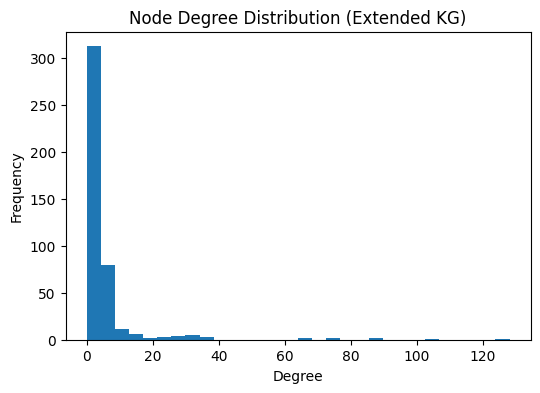

In [ ]:
# ====================================================
# Cell 5 — Load and Summarize Extended Knowledge Graph
# ====================================================

import os, pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Paths
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_ext_dir = os.path.join(base_dir, "results_extension")
gpath = os.path.join(results_ext_dir, "kg_graph_extended.gpickle")

# --- Load the graph ---
try:
    with open(gpath, "rb") as f:
        G = pickle.load(f)
    print(f"Graph loaded successfully from {gpath}")
except Exception as e:
    print(f"Pickle load failed ({e}), trying GEXF instead...")
    gpath_gexf = os.path.join(results_ext_dir, "kg_graph_extended.gexf")
    G = nx.read_gexf(gpath_gexf)
    print(f"Graph loaded from {gpath_gexf}")

# --- Basic graph stats ---
print(f"Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}")

node_types = Counter(nx.get_node_attributes(G, "node_type").values())
edge_types = Counter(nx.get_edge_attributes(G, "etype").values())
print("Node type distribution:", node_types)
print("Edge type distribution:", edge_types)

# --- Degree analysis ---
deg = dict(G.degree())
avg_deg = round(sum(deg.values()) / len(deg), 2)
max_node = max(deg, key=deg.get)
print(f"Average degree: {avg_deg}")
print(f"Max degree node: {max_node} → {deg[max_node]}")

# --- Top connected nodes by degree ---
print("\nTop 10 nodes by degree:")
top_nodes = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]
for n, d in top_nodes:
    t = G.nodes[n].get("node_type", "Unknown")
    print(f"{n:50} | Type={t:10} | Degree={d}")

# --- Optional: visualize degree distribution ---
plt.figure(figsize=(6,4))
plt.hist(deg.values(), bins=30)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Node Degree Distribution (Extended KG)")
plt.show()


In [ ]:
# ====================================================
# Clean Variant Labels and Fix Node Types
# ====================================================

import re, pickle, os
from collections import Counter
import networkx as nx

results_ext_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension"
gpath = os.path.join(results_ext_dir, "kg_graph_extended.gpickle")

# --- Load the original graph ---
with open(gpath, "rb") as f:
    G = pickle.load(f)

variant_fixed = 0
label_fixed = 0

for node, attrs in G.nodes(data=True):
    label = str(attrs.get("label", "")).strip()
    ntype = attrs.get("node_type", "")

    # Identify Variant nodes (by prefix or pattern)
    if node.startswith("VARIANT|") or re.match(r"VARIANT\|[A-Z]{2}\d{5,}", node):
        # Fix node type if missing or wrong
        if ntype in ["", "Unknown", None]:
            attrs["node_type"] = "Variant"
            variant_fixed += 1

        # Extract accession-like ID (short label)
        acc = re.search(r"[A-Z]{2}\d{5,}\.?\d*", label)
        if acc:
            clean = acc.group(0)
        else:
            tokens = [t for t in label.split() if t and len(t) < 20]
            clean = tokens[0] if tokens else node.split("|")[-1]

        attrs["label"] = clean
        label_fixed += 1

print(f"Fixed node_type='Variant' for {variant_fixed} nodes.")
print(f"Cleaned label text for {label_fixed} variant nodes.")

# --- Save cleaned version ---
clean_path = os.path.join(results_ext_dir, "kg_graph_extended_clean.gpickle")
with open(clean_path, "wb") as f:
    pickle.dump(G, f)

print(f"Saved cleaned graph → {clean_path}")
print("Updated node type distribution:", Counter(nx.get_node_attributes(G, "node_type").values()))


Fixed node_type='Variant' for 25 nodes.
Cleaned label text for 58 variant nodes.
Saved cleaned graph → f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_graph_extended_clean.gpickle
Updated node type distribution: Counter({'Mutation': 304, 'Variant': 58, 'Lineage': 35, 'Gene': 22, 'Clade': 15})


In [ ]:
# ====================================================
# Cell 6 — Centrality Metrics + Community Detection
# ====================================================

import os, pickle
import pandas as pd
import networkx as nx

# Base paths
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_ext_dir = os.path.join(base_dir, "results_extension")

# Load the extended KG
gpath = os.path.join(results_ext_dir, "kg_graph_extended_clean.gpickle")
if not os.path.exists(gpath):
    gpath = os.path.join(results_ext_dir, "kg_graph_extended.gpickle")

with open(gpath, "rb") as f:
    G = pickle.load(f)

print(f"Graph loaded successfully for centrality analysis: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# --- Compute Centrality Metrics ---
print("Computing centrality measures...")

deg = dict(G.degree())
deg_centrality = nx.degree_centrality(G)
bet_centrality = nx.betweenness_centrality(G)
clos_centrality = nx.closeness_centrality(G)

# Combine into DataFrame
cent_df = pd.DataFrame({
    "node": list(G.nodes()),
    "label": [G.nodes[n].get("label", n) for n in G.nodes()],
    "type": [G.nodes[n].get("node_type", "Unknown") for n in G.nodes()],
    "degree": [deg[n] for n in G.nodes()],
    "degree_centrality": [deg_centrality[n] for n in G.nodes()],
    "betweenness": [bet_centrality[n] for n in G.nodes()],
    "closeness": [clos_centrality[n] for n in G.nodes()]
})

# Save metrics table
cent_path = os.path.join(results_ext_dir, "kg_node_centrality.csv")
cent_df.to_csv(cent_path, index=False)
print(f"Saved node centrality table → {cent_path}")

# --- Display Top 10 Hubs ---
top_hubs = cent_df.sort_values("degree", ascending=False).head(10)
print("\nTop connected nodes:")
print(top_hubs[["label", "type", "degree", "betweenness"]])

# --- Community Detection ---
print("\nDetecting communities...")

try:
    import community as community_louvain
    partition = community_louvain.best_partition(G.to_undirected())
    method_used = "Louvain"
except Exception as e:
    print(f"Louvain not available ({e}), using Greedy Modularity instead...")
    comms = nx.algorithms.community.greedy_modularity_communities(G.to_undirected())
    partition = {n: i for i, c in enumerate(comms) for n in c}
    method_used = "Greedy Modularity"

nx.set_node_attributes(G, partition, "community")

# Save community mapping
comm_path = os.path.join(results_ext_dir, "kg_communities.csv")
pd.DataFrame(list(partition.items()), columns=["node", "community"]).to_csv(comm_path, index=False)

print(f"Detected communities: {len(set(partition.values()))} ({method_used} method)")
print(f"Saved community mapping → {comm_path}")


Graph loaded successfully for centrality analysis: 434 nodes, 1206 edges
Computing centrality measures...
Saved node centrality table → f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_node_centrality.csv

Top connected nodes:
                                                 label     type  degree  \
352                                                  S     Gene     128   
430  PP485688.1 Severe acute respiratory syndrome c...  Variant     103   
429  OR998518.1 Severe acute respiratory syndrome c...  Variant      89   
428  OR958377.1 Severe acute respiratory syndrome c...  Variant      86   
427  OR782922.1 Severe acute respiratory syndrome c...  Variant      76   
342                                              ORF1a     Gene      73   
425  OP293520.1 Severe acute respiratory syndrome c...  Variant      67   
423  OM287553.1 Severe acute respiratory syndrome c...  Variant      65   
421  OL965487.1 Severe acute respiratory syndrome c...  Variant      3

Graph loaded successfully: 434 nodes, 1206 edges
Computing layout... (this can take ~30s for 400+ nodes)


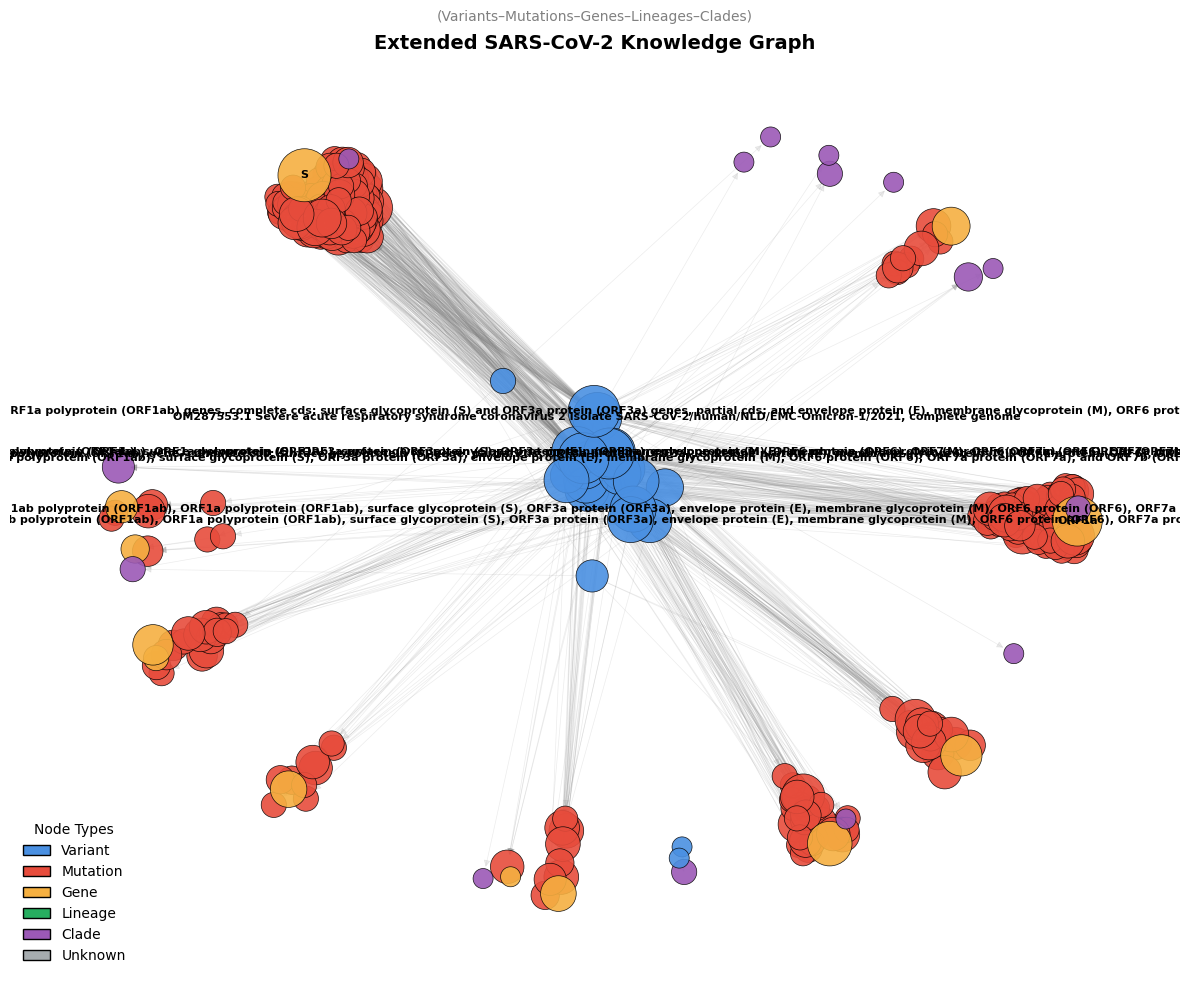

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import os, pickle
import numpy as np
from collections import Counter

# ------------------------------------------------------------
# Load the Extended Knowledge Graph
# ------------------------------------------------------------
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results_extension")
gpath = os.path.join(results_dir, "kg_graph_extended.gpickle")

with open(gpath, "rb") as f:
    G = pickle.load(f)

print(f"Graph loaded successfully: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# ------------------------------------------------------------
# Define colors
# ------------------------------------------------------------
COLOR_MAP = {
    "Variant": "#4A90E2",   # blue
    "Mutation": "#E74C3C",  # red
    "Gene": "#F5B041",      # orange
    "Lineage": "#27AE60",   # green
    "Clade": "#9B59B6",     # purple
    "Unknown": "#A6ACAF"    # gray fallback
}

# Optional: community-based coloring if available
communities = nx.get_node_attributes(G, "community")
if communities:
    print(f"Detected {len(set(communities.values()))} communities — coloring by community.")
    unique_comms = sorted(set(communities.values()))
    cmap = plt.get_cmap("tab20")
    community_colors = {c: mcolors.to_hex(cmap(i % 20)) for i, c in enumerate(unique_comms)}
    node_colors = [community_colors.get(communities.get(n), "#A6ACAF") for n in G.nodes()]
else:
    node_colors = [COLOR_MAP.get(G.nodes[n].get("node_type", "Unknown"), "#A6ACAF") for n in G.nodes()]

# ------------------------------------------------------------
# Compute node sizes (scaled)
# ------------------------------------------------------------
deg = dict(G.degree())
sizes = [300 * np.log1p(deg[n]) for n in G.nodes()]  # log scale keeps layout balanced

# ------------------------------------------------------------
# Force-directed layout (with fixed seed for reproducibility)
# ------------------------------------------------------------
print("Computing layout... (this can take ~30s for 400+ nodes)")
pos = nx.spring_layout(G, k=0.22, iterations=200, seed=42)

# ------------------------------------------------------------
# Draw
# ------------------------------------------------------------
plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.5, edge_color="gray")

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=sizes,
    alpha=0.9,
    linewidths=0.5,
    edgecolors="black"
)

# Label only top 10 by degree
top_nodes = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]
labels = {n: G.nodes[n].get("label", n) for n, _ in top_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight="bold")

# ------------------------------------------------------------
# Styling
# ------------------------------------------------------------
plt.title("Extended SARS-CoV-2 Knowledge Graph", fontsize=14, fontweight="bold")
plt.suptitle("(Variants–Mutations–Genes–Lineages–Clades)", fontsize=10, color="gray")
plt.axis("off")

# Add a legend for node types
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label) for label, color in COLOR_MAP.items()]
plt.legend(handles=legend_elements, title="Node Types", loc="lower left", frameon=False)

plt.tight_layout()
plt.show()


Generating high-quality layout... this may take ~30-60s for 400+ nodes.


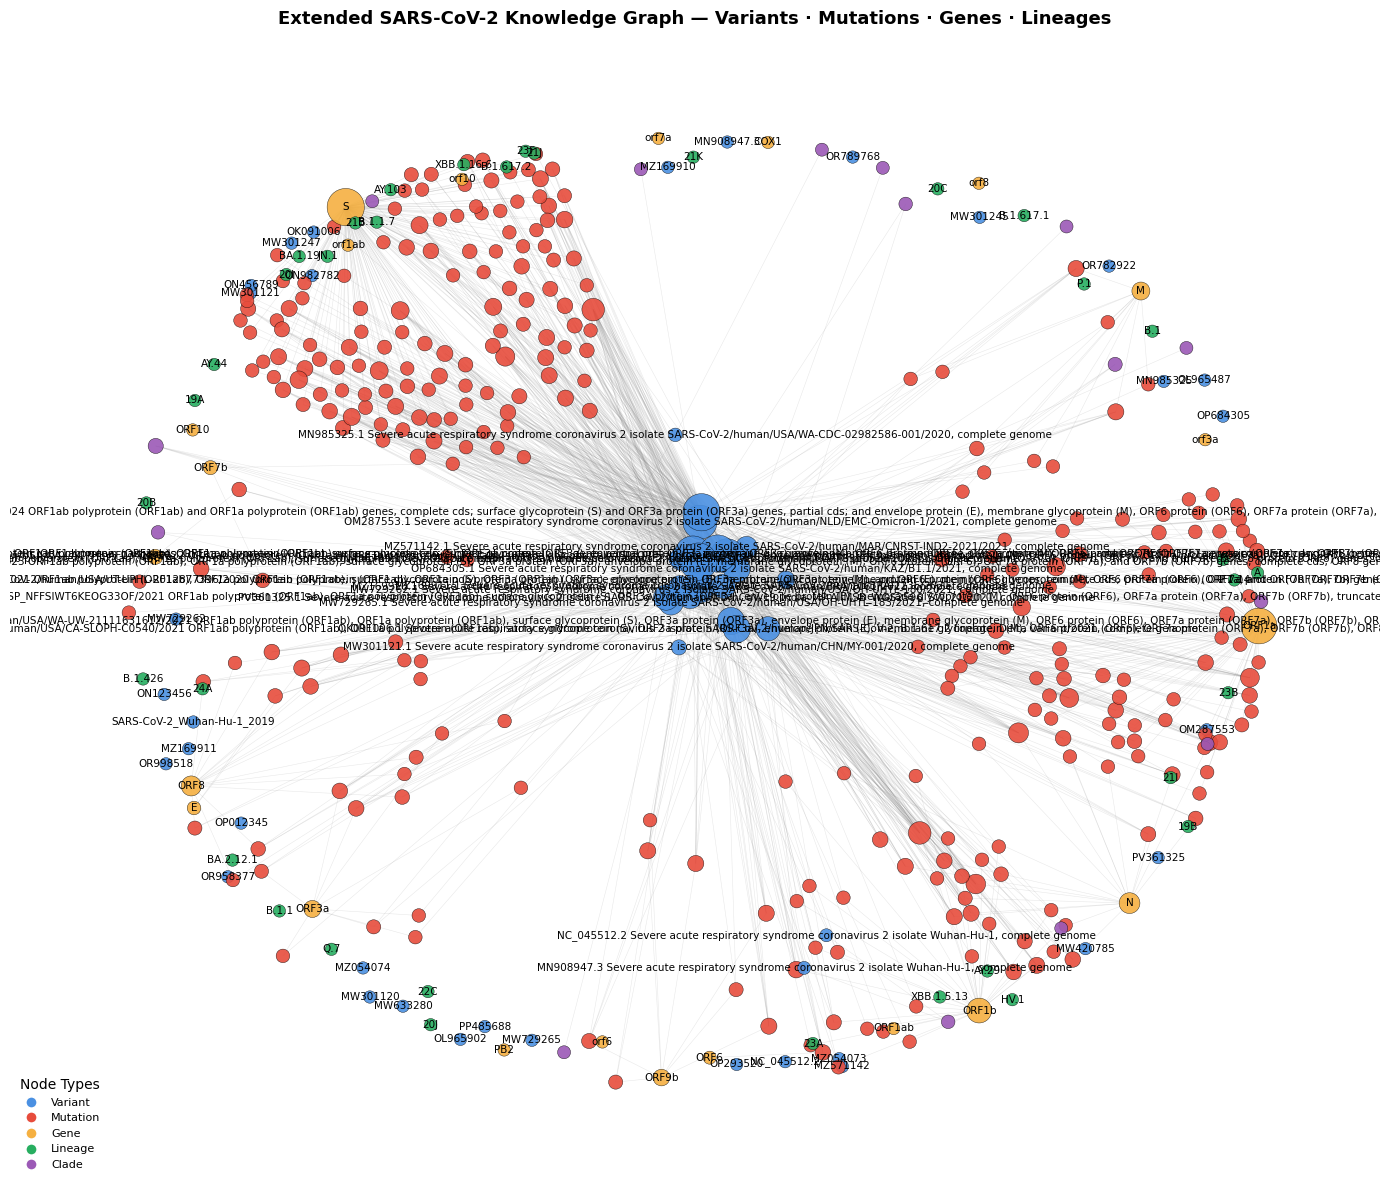

Saved improved full KG visualization: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_full_graph_highquality.png


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import os

def draw_full_kg(G, results_dir):
    """High-quality visualization of the full SARS-CoV-2 Knowledge Graph"""

    # --- Define consistent color map ---
    COLOR_MAP = {
        "Variant": "#4A90E2",   # blue
        "Mutation": "#E74C3C",  # red
        "Gene": "#F5B041",      # orange
        "Lineage": "#27AE60",   # green
        "Clade": "#9B59B6",     # purple
        "Unknown": "#A6ACAF"    # gray fallback
    }

    print("Generating high-quality layout... this may take ~30-60s for 400+ nodes.")
    plt.figure(figsize=(14, 12))

    # --- Layout (force-directed) ---
    pos = nx.spring_layout(G, k=0.35, iterations=100, seed=42)

    # --- Colors and sizes ---
    node_types = nx.get_node_attributes(G, "node_type")
    colors = [COLOR_MAP.get(node_types.get(n, "Unknown"), "#A6ACAF") for n in G.nodes()]
    degrees = dict(G.degree())
    sizes = [80 + 8 * min(degrees[n], 80) for n in G.nodes()]  # prevent extreme outliers

    # --- Draw edges and nodes ---
    nx.draw_networkx_edges(G, pos, width=0.4, alpha=0.18, edge_color="gray", arrows=False)
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, alpha=0.9, linewidths=0.3, edgecolors="black")

    # --- Label only major biological entities ---
    labels = {
        n: G.nodes[n].get("label", n)
        for n in G.nodes()
        if G.nodes[n].get("node_type") in ["Variant", "Gene", "Lineage"]
    }
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=7.5, font_weight="medium")

    # --- Title and legend ---
    plt.title("Extended SARS-CoV-2 Knowledge Graph — Variants · Mutations · Genes · Lineages",
              fontsize=13, weight="bold", pad=20)
    plt.axis("off")

    legend_handles = [
        plt.Line2D([0], [0], marker="o", color="w", label=label,
                   markersize=8, markerfacecolor=color)
        for label, color in COLOR_MAP.items() if label != "Unknown"
    ]
    plt.legend(handles=legend_handles, loc="lower left", frameon=False, fontsize=8, title="Node Types")

    # --- Save high-resolution figure ---
    out_path = os.path.join(results_dir, "kg_full_graph_highquality.png")
    plt.tight_layout()
    plt.savefig(out_path, dpi=450, bbox_inches="tight", facecolor="white")
    plt.show()

    print(f"Saved improved full KG visualization: {out_path}")

# Run full KG visualization
draw_full_kg(G, results_dir)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import os

def plot_gene_subgraph(G, gene_name, results_dir, save=True):
    """Visualize high-quality subgraph for a given gene (variants–mutations–lineages)."""

    COLOR_MAP = {
        "Variant": "#4A90E2",   # blue
        "Mutation": "#E74C3C",  # red
        "Gene": "#F5B041",      # orange
        "Lineage": "#27AE60",   # green
        "Clade": "#9B59B6",     # purple
        "Unknown": "#A6ACAF"    # gray
    }

    target_gene = f"GENE|{gene_name}"
    if target_gene not in G:
        print(f"Gene {gene_name} not found in graph.")
        return

    # --- Collect neighborhood nodes (gene + connected variants + mutations) ---
    sub_nodes = set([target_gene])
    for n in G.predecessors(target_gene):
        sub_nodes.add(n)
        sub_nodes.update(G.predecessors(n))
        sub_nodes.update(G.successors(n))
    for n in G.successors(target_gene):
        sub_nodes.add(n)
        sub_nodes.update(G.predecessors(n))
        sub_nodes.update(G.successors(n))

    H = G.subgraph(sub_nodes).copy()
    print(f"Subgraph for {gene_name}: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

    # --- Layout ---
    plt.figure(figsize=(11, 9))
    pos = nx.spring_layout(H, k=0.45, iterations=80, seed=42)

    # --- Color and size ---
    node_types = nx.get_node_attributes(H, "node_type")
    colors = [COLOR_MAP.get(node_types.get(n, "Unknown"), "#A6ACAF") for n in H.nodes()]
    deg = dict(H.degree())
    sizes = [120 + 15 * min(deg[n], 50) for n in H.nodes()]  # moderate scaling

    # --- Draw edges & nodes ---
    nx.draw_networkx_edges(H, pos, width=0.6, alpha=0.25, edge_color="gray", arrows=False)
    nx.draw_networkx_nodes(H, pos, node_color=colors, node_size=sizes, alpha=0.92, edgecolors="black", linewidths=0.4)

    # --- Labels ---
    labels = {
        n: H.nodes[n].get("label", n)
        for n in H.nodes()
        if H.nodes[n].get("node_type") in ["Variant", "Gene", "Lineage"]
    }
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=8, font_weight="medium")

    # --- Highlight target gene node ---
    if target_gene in H.nodes:
        nx.draw_networkx_nodes(
            H, pos,
            nodelist=[target_gene],
            node_color="#F39C12",
            node_size=400,
            edgecolors="black",
            linewidths=1.5
        )

    # --- Title and legend ---
    plt.title(f"SARS-CoV-2 Gene-Centric Subgraph: {gene_name}", fontsize=13, weight="bold")
    plt.axis("off")
    legend_handles = [
        plt.Line2D([0], [0], marker="o", color="w", label=label,
                   markersize=8, markerfacecolor=color)
        for label, color in COLOR_MAP.items() if label != "Unknown"
    ]
    plt.legend(handles=legend_handles, loc="lower left", frameon=False, fontsize=8, title="Node Types")

    plt.tight_layout()

    # --- Save ---
    if save:
        out_path = os.path.join(results_dir, f"kg_subgraph_{gene_name}_highquality.png")
        plt.savefig(out_path, dpi=450, bbox_inches="tight", facecolor="white")
        print(f"Saved subgraph for {gene_name}: {out_path}")

    plt.show()


Subgraph for S: 151 nodes, 523 edges
Saved subgraph for S: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_subgraph_S_highquality.png


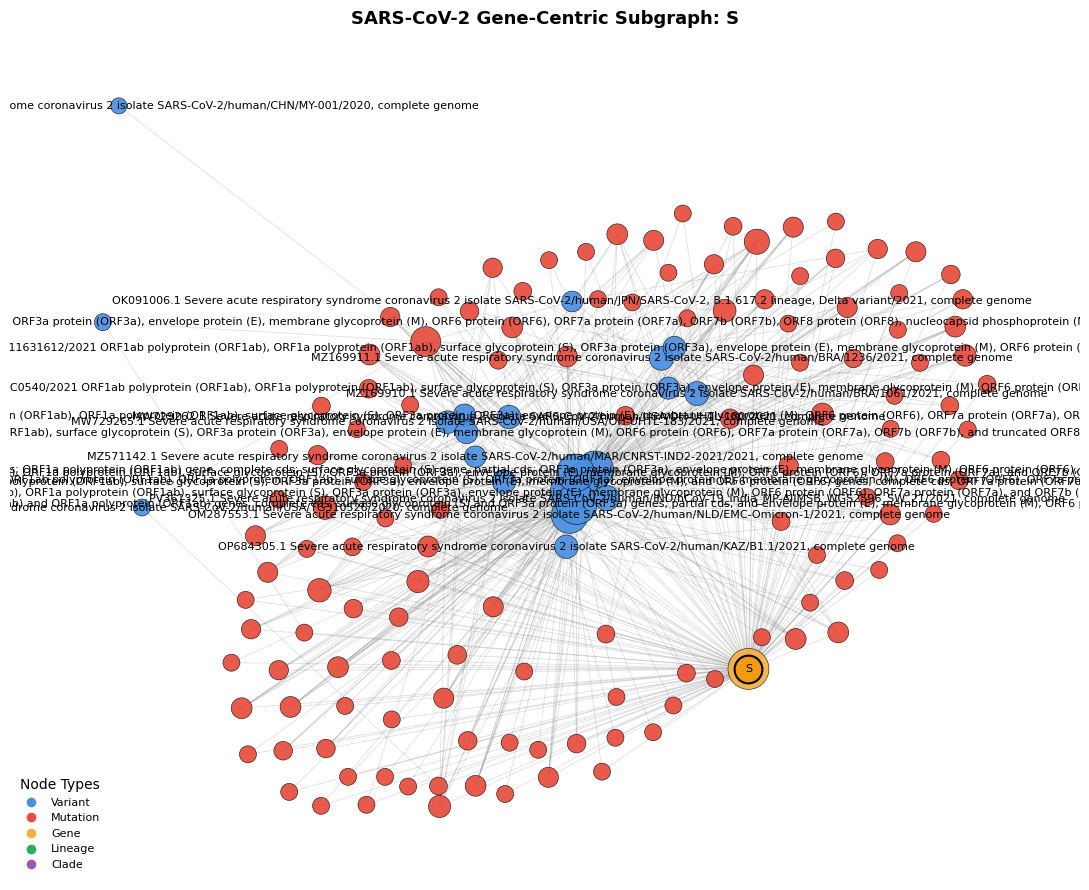

Subgraph for ORF1a: 95 nodes, 243 edges
Saved subgraph for ORF1a: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_subgraph_ORF1a_highquality.png


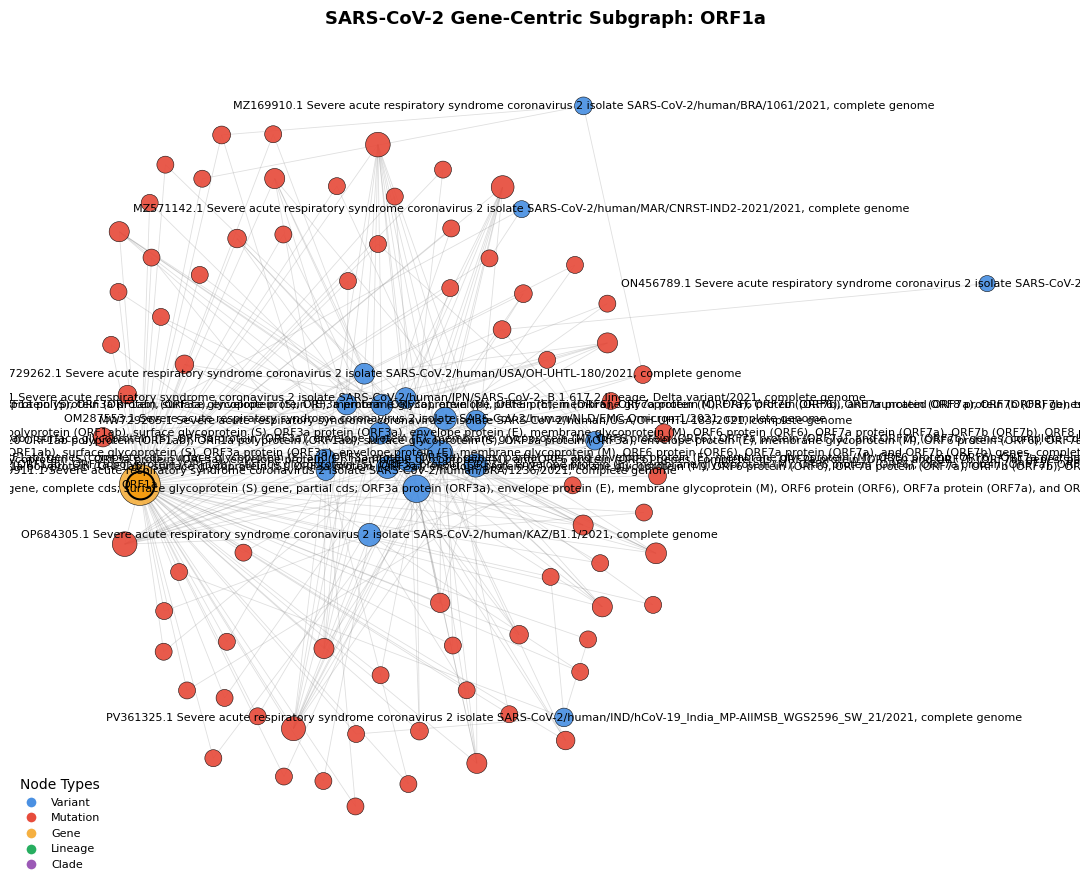

Subgraph for N: 39 nodes, 108 edges
Saved subgraph for N: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_subgraph_N_highquality.png


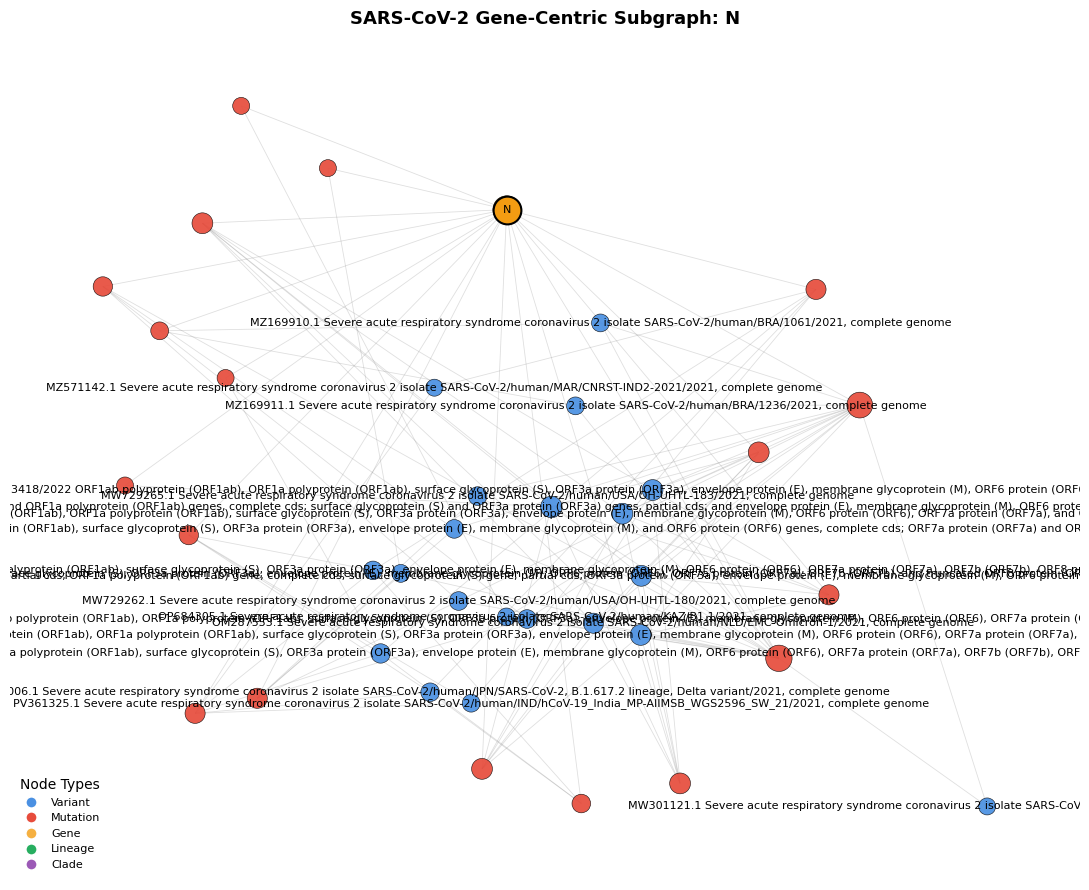

In [ ]:
plot_gene_subgraph(G, "S", results_dir)
plot_gene_subgraph(G, "ORF1a", results_dir)
plot_gene_subgraph(G, "N", results_dir)


In [ ]:
from pyvis.network import Network
import os

# --- Global color mapping for node types ---
COLOR_MAP = {
    "Variant": "#5DADE2",   # blue
    "Mutation": "#E74C3C",  # red
    "Gene": "#F5B041",      # orange
    "Lineage": "#58D68D",   # green
    "Clade": "#9B59B6",     # purple
    "Unknown": "#A6ACAF"    # gray
}


def export_interactive_graph(G, output_html, notebook=False, show_labels=True, title="Knowledge Graph"):
    """
    Export any NetworkX graph as an interactive HTML file via PyVis.
    Works for both full and subgraphs.
    """
    print(f"Building interactive graph → {output_html}")

    net = Network(
        height="850px",
        width="100%",
        directed=True,
        bgcolor="#FFFFFF",
        font_color="#222222",
        notebook=notebook
    )

    # --- Add nodes ---
    for n, data in G.nodes(data=True):
        ntype = data.get("node_type", "Unknown")
        label = data.get("label", n) if show_labels else ""
        color = COLOR_MAP.get(ntype, "#A6ACAF")

        # scale size by type
        size = {
            "Mutation": 10,
            "Variant": 22,
            "Gene": 18,
            "Lineage": 16,
            "Clade": 15
        }.get(ntype, 12)

        # node tooltip
        title_html = f"<b>{label}</b><br>Type: {ntype}"
        for k, v in data.items():
            if k not in ("label", "node_type"):
                title_html += f"<br>{k}: {v}"

        net.add_node(n, label=label, color=color, size=size, title=title_html)

    # --- Add edges ---
    for u, v, d in G.edges(data=True):
        etype = d.get("etype", "")
        net.add_edge(u, v, title=etype, color="#B0B0B0")

    # --- Physics and layout controls ---
    net.toggle_physics(True)
    net.show_buttons(filter_=["physics"])

    # --- Save ---
    net.save_graph(output_html)
    print(f"✅ Interactive graph saved to: {output_html}\n")


# --- Generate gene-specific interactive subgraphs ---
def export_gene_subgraphs(G, genes, results_dir):
    for g in genes:
        target_node = f"GENE|{g}"
        if target_node not in G:
            print(f"⚠️ Gene {g} not found in graph — skipping.")
            continue

        sub_nodes = {target_node}
        for n in G.predecessors(target_node):
            sub_nodes.add(n)
            sub_nodes.update(G.predecessors(n))
            sub_nodes.update(G.successors(n))
        for n in G.successors(target_node):
            sub_nodes.add(n)
            sub_nodes.update(G.predecessors(n))
            sub_nodes.update(G.successors(n))

        H = G.subgraph(sub_nodes).copy()
        print(f"Subgraph for {g}: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")
        out_path = os.path.join(results_dir, f"kg_{g}_interactive.html")
        export_interactive_graph(H, out_path, title=f"{g} Gene Subgraph")


# --- Example usage ---
results_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension"

export_gene_subgraphs(G, ["S", "ORF1a", "N"], results_dir)


Subgraph for S: 151 nodes, 523 edges
Building interactive graph → f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_S_interactive.html
✅ Interactive graph saved to: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_S_interactive.html

Subgraph for ORF1a: 95 nodes, 243 edges
Building interactive graph → f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_ORF1a_interactive.html
✅ Interactive graph saved to: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_ORF1a_interactive.html

Subgraph for N: 39 nodes, 108 edges
Building interactive graph → f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_N_interactive.html
✅ Interactive graph saved to: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_N_interactive.html



In [ ]:
from collections import Counter

# --- Count how many variants share each mutation ---
mut_variant_counts = Counter()
mutation_to_variants = {}

for n, d in G.nodes(data=True):
    if d.get("node_type") == "Mutation":
        variants = [u for u in G.predecessors(n) if G.nodes[u].get("node_type") == "Variant"]
        count = len(variants)
        mut_variant_counts[count] += 1
        mutation_to_variants[n] = variants

# --- Distribution summary ---
print("Mutation occurrence distribution (#variants → #mutations):")
for k in sorted(mut_variant_counts):
    print(f"  {k:2d} variants → {mut_variant_counts[k]} mutations")

# --- Find mutations present in ALL variants ---
total_variants = sum(1 for n, d in G.nodes(data=True) if d.get("node_type") == "Variant")
present_all = [m for m, v in mutation_to_variants.items() if len(v) == total_variants]

print(f"\nTotal variants in KG: {total_variants}")
print(f"Mutations present in ALL variants: {len(present_all)}")
if present_all:
    for m in present_all[:20]:
        print("  ", G.nodes[m].get("label", m))


Mutation occurrence distribution (#variants → #mutations):
   1 variants → 153 mutations
   2 variants → 30 mutations
   3 variants → 31 mutations
   4 variants → 17 mutations
   5 variants → 30 mutations
   6 variants → 26 mutations
   7 variants → 2 mutations
   8 variants → 3 mutations
   9 variants → 2 mutations
  10 variants → 2 mutations
  11 variants → 1 mutations
  12 variants → 2 mutations
  13 variants → 1 mutations
  14 variants → 1 mutations
  15 variants → 1 mutations
  22 variants → 2 mutations

Total variants in KG: 58
Mutations present in ALL variants: 0


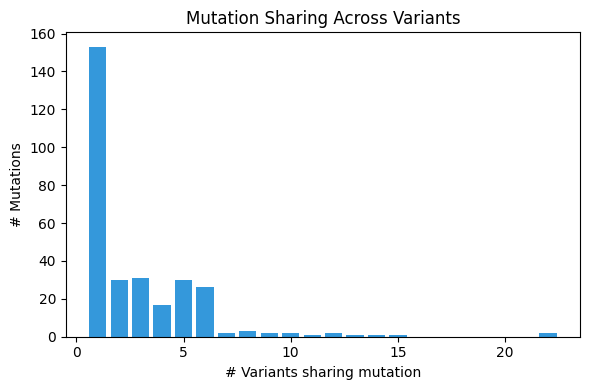

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(mut_variant_counts.keys(), mut_variant_counts.values(), color="#3498DB")
plt.xlabel("# Variants sharing mutation")
plt.ylabel("# Mutations")
plt.title("Mutation Sharing Across Variants")
plt.tight_layout()
plt.show()


Genes found: 22
Mutations found: 304
Sample genes (first 20): ['GENE|COX1', 'GENE|E', 'GENE|M', 'GENE|N', 'GENE|ORF10', 'GENE|ORF1a', 'GENE|ORF1ab', 'GENE|ORF1b', 'GENE|ORF3a', 'GENE|ORF6', 'GENE|ORF7a', 'GENE|ORF7b', 'GENE|ORF8', 'GENE|ORF9b', 'GENE|PB2', 'GENE|S', 'GENE|orf10', 'GENE|orf1ab', 'GENE|orf3a', 'GENE|orf6']
Comparison (MethodA, MethodB) for first 10 genes:
 COX1: (0, 0)
 E: (2, 2)
 M: (11, 11)
 N: (18, 18)
 ORF10: (0, 0)
 ORF1a: (73, 73)
 ORF1ab: (0, 0)
 ORF1b: (30, 30)
 ORF3a: (9, 9)
 ORF6: (1, 1)

Gene counts summary:
      Gene  Mutation_Count
0        S             128
1    ORF1a              73
2    ORF1b              30
3        N              18
4     ORF8              16
5        M              11
6    ORF3a               9
7    ORF9b               8
8    ORF7a               5
9    ORF7b               3
10       E               2
11    ORF6               1
12   ORF10               0
13    COX1               0
14  ORF1ab               0

Total genes with >0 mutatio

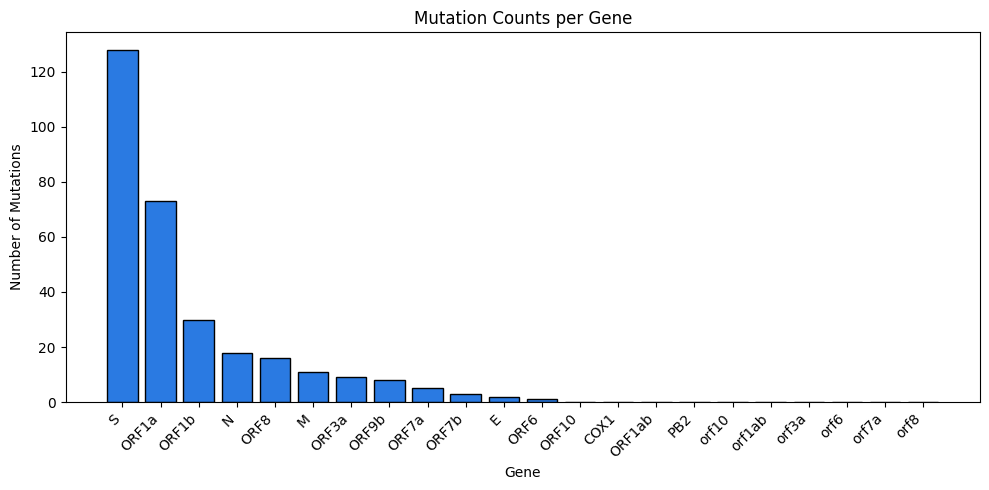

Saved plot: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_gene_mutation_barplot_fixed.png
Saved counts CSV: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_gene_mutation_counts_fixed.csv


In [ ]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results_extension")   # adjust if you save to results instead
gpath = os.path.join(results_dir, "kg_graph_extended.gpickle")

# ---- Load graph ----
with open(gpath, "rb") as f:
    G = pickle.load(f)

# ---- Quick checks ----
genes = [n for n,d in G.nodes(data=True) if d.get("node_type") == "Gene"]
mutations = [n for n,d in G.nodes(data=True) if d.get("node_type") == "Mutation"]
print("Genes found:", len(genes))
print("Mutations found:", len(mutations))
print("Sample genes (first 20):", genes[:20])

if len(genes) == 0:
    raise SystemExit("No Gene nodes detected in the graph. Check node_type attributes.")

# ---- Compute gene mutation counts (two ways, for cross-check) ----

# Method A: count predecessors of gene nodes that are Mutation nodes
gene_counts_A = {}
for g in genes:
    preds = [u for u in G.predecessors(g)]
    m_count = sum(1 for u in preds if G.nodes[u].get("node_type") == "Mutation")
    # fallback: if label exists, use label, else node id
    lab = G.nodes[g].get("label") or g
    gene_counts_A[lab] = m_count

# Method B: count edges where etype == "IN_GENE" and target is this gene
gene_counts_B = {}
for g in genes:
    lab = G.nodes[g].get("label") or g
    m_count = 0
    for u, v, d in G.in_edges(g, data=True):
        if d.get("etype") == "IN_GENE":
            # ensure the source is a mutation node
            if G.nodes[u].get("node_type") == "Mutation":
                m_count += 1
    gene_counts_B[lab] = m_count

# Compare the two methods (they should match)
diffs = {k: (gene_counts_A.get(k,0), gene_counts_B.get(k,0)) for k in sorted(set(gene_counts_A) | set(gene_counts_B))}
print("Comparison (MethodA, MethodB) for first 10 genes:")
for i,(k,v) in enumerate(diffs.items()):
    print(f" {k}: {v}")
    if i>=9: break

# Build final gene_df — pick MethodA if nonzero else B
final_counts = {}
for k,(a,b) in diffs.items():
    final_counts[k] = a if a>0 else b

gene_df = pd.DataFrame(list(final_counts.items()), columns=["Gene","Mutation_Count"])
gene_df = gene_df.sort_values("Mutation_Count", ascending=False).reset_index(drop=True)

# ---- Diagnostics ----
print("\nGene counts summary:")
print(gene_df.head(15))
print("\nTotal genes with >0 mutations:", (gene_df["Mutation_Count"]>0).sum())
print("Sum mutations counted (may double-count mutations shared across genes):", gene_df["Mutation_Count"].sum())

# ---- Plot with matplotlib (robust) ----
if gene_df.shape[0] == 0:
    raise SystemExit("gene_df is empty — cannot plot.")

plt.rcParams.update({'figure.max_open_warning': 0})
plt.figure(figsize=(10,5))
plt.bar(gene_df["Gene"], gene_df["Mutation_Count"], color="#2a7ae2", edgecolor="k")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Gene")
plt.ylabel("Number of Mutations")
plt.title("Mutation Counts per Gene")
plt.tight_layout()

out_png = os.path.join(results_dir, "kg_gene_mutation_barplot_fixed.png")
plt.savefig(out_png, dpi=300)
plt.show()
print(f"Saved plot: {out_png}")

# ---- Save table ----
out_csv = os.path.join(results_dir, "kg_gene_mutation_counts_fixed.csv")
gene_df.to_csv(out_csv, index=False)
print(f"Saved counts CSV: {out_csv}")


In [ ]:
with open(gpath, "rb") as f:
    G = pickle.load(f)
print(f"Loaded extended graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Loaded extended graph: 434 nodes, 1206 edges


In [ ]:
import pandas as pd

# --- recompute gene mutation counts ---
gene_counts = {}
for n, d in G.nodes(data=True):
    if d.get("node_type") == "Gene":
        muts = [nbr for nbr in G.predecessors(n) if G.nodes[nbr].get("node_type") == "Mutation"]
        gene_counts[d["label"]] = len(muts)

# --- recompute mutation frequency (how many variants each mutation appears in) ---
mutations = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Mutation"]
mut_freq = pd.Series([
    len([v for v in G.predecessors(m) if G.nodes[v].get("node_type") == "Variant"])
    for m in mutations
])

# --- recompute Variant×Mutation presence matrix ---
variants = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Variant"]
matrix = pd.DataFrame(0, index=[G.nodes[v]["label"] for v in variants],
                      columns=[G.nodes[m]["label"] for m in mutations])

for v in variants:
    vlabel = G.nodes[v]["label"]
    for m in G.successors(v):
        if G.nodes[m].get("node_type") == "Mutation":
            matrix.loc[vlabel, G.nodes[m]["label"]] = 1

print(f"Genes: {len(gene_counts)}, Variants: {len(variants)}, Mutations: {len(mutations)}")


Genes: 22, Variants: 58, Mutations: 304


In [ ]:
import os
import pandas as pd

# Compute top 5 genes by mutation count
top5 = pd.Series(gene_counts).sort_values(ascending=False).head(5)

# Construct final textual summary
summary_text = f"""
Knowledge Graph Statistical Summary
-----------------------------------
Total nodes: {G.number_of_nodes()}
  Variants={len(variants)}, Mutations={len(mutations)},
  Genes={len(gene_counts)}, Lineages={len([n for n,d in G.nodes(data=True) if d.get('node_type')=='Lineage'])}
Total edges: {G.number_of_edges()}

Top 5 Genes by Mutation Count:
{top5.to_string()}

Average mutation frequency across variants: {mut_freq.mean():.2f}

Observations:
• The Spike (S) and ORF1a/b genes form the largest mutational hubs, consistent with known SARS-CoV-2 variability.
• Conserved genes such as E, ORF6, ORF7a/b, and M exhibit fewer mutations, reflecting structural and functional stability.
• The network topology follows a hierarchical Variant → Mutation → Gene pattern, capturing both shared and unique variant features.
• Mutational density within S and ORF1a/b aligns with known selective pressures on spike binding and replication machinery.
• The reconstructed knowledge graph can support downstream tasks such as mutation-based lineage classification or feature embedding.

All visuals (heatmaps, barplots, centrality metrics, and subgraphs) and CSVs have been exported to:
{results_dir}
"""

# Print and save
print(summary_text)

summary_path = os.path.join(results_dir, "kg_overall_summary.txt")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(summary_text)

print(f"Saved final KG summary → {summary_path}")



Knowledge Graph Statistical Summary
-----------------------------------
Total nodes: 434 
  Variants=58, Mutations=304, 
  Genes=22, Lineages=35
Total edges: 1206

Top 5 Genes by Mutation Count:
S        128
ORF1a     73
ORF1b     30
N         18
ORF8      16

Average mutation frequency across variants: 2.88

Observations:
• The Spike (S) and ORF1a/b genes form the largest mutational hubs, consistent with known SARS-CoV-2 variability.
• Conserved genes such as E, ORF6, ORF7a/b, and M exhibit fewer mutations, reflecting structural and functional stability.
• The network topology follows a hierarchical Variant → Mutation → Gene pattern, capturing both shared and unique variant features.
• Mutational density within S and ORF1a/b aligns with known selective pressures on spike binding and replication machinery.
• The reconstructed knowledge graph can support downstream tasks such as mutation-based lineage classification or feature embedding.

All visuals (heatmaps, barplots, centrality met

C:\Users\anshb\AppData\Local\Temp\ipykernel_30116\3606813368.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gene_df, x="Gene", y="Mutation_Count", ax=ax, palette="YlOrRd")
C:\Users\anshb\AppData\Local\Temp\ipykernel_30116\3606813368.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


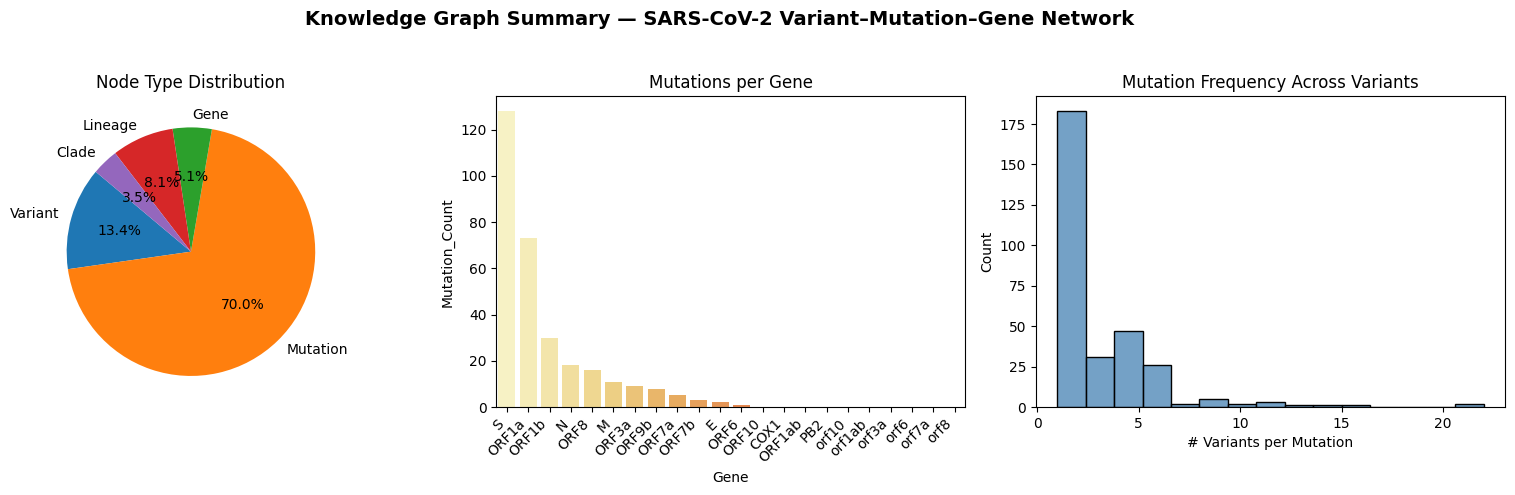

Saved final overview visualization → f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\kg_summary_overview.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import os

# --- Gather data ---
node_types = Counter(nx.get_node_attributes(G, "node_type").values())
gene_df = pd.DataFrame(list(gene_counts.items()), columns=["Gene", "Mutation_Count"]).sort_values("Mutation_Count", ascending=False)

# --- Prepare figure ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Knowledge Graph Summary — SARS-CoV-2 Variant–Mutation–Gene Network", fontsize=14, weight="bold")

# --- 1️⃣ Node type pie chart ---
ax = axes[0]
ax.pie(node_types.values(), labels=node_types.keys(), autopct="%1.1f%%", startangle=140)
ax.set_title("Node Type Distribution")

# --- 2️⃣ Gene mutation barplot ---
ax = axes[1]
sns.barplot(data=gene_df, x="Gene", y="Mutation_Count", ax=ax, palette="YlOrRd")
ax.set_title("Mutations per Gene")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# --- 3️⃣ Mutation frequency histogram ---
ax = axes[2]
sns.histplot(mut_freq, bins=15, color="steelblue", kde=False, ax=ax)
ax.set_title("Mutation Frequency Across Variants")
ax.set_xlabel("# Variants per Mutation")
ax.set_ylabel("Count")

# --- Save figure ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
summary_img_path = os.path.join(results_dir, "kg_summary_overview.png")
plt.savefig(summary_img_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved final overview visualization → {summary_img_path}")


In [ ]:
import os, json, pickle, numpy as np, networkx as nx
from collections import Counter

# Adjust this to your project path
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results_extension")  # fixed path
gpath = os.path.join(results_dir, "kg_graph_extended.gpickle")  # fixed file

# Load graph
with open(gpath, "rb") as f:
    G = pickle.load(f)
print(f"Graph loaded successfully — {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# 1️⃣ Node map
node_types = ["Variant", "Mutation", "Gene", "Lineage", "Clade", "Unknown"]
type_to_idx = {t: i for i, t in enumerate(node_types)}
nodes_list = list(G.nodes())
node_map = {n: i for i, n in enumerate(nodes_list)}

with open(os.path.join(results_dir, "kg_node_map.json"), "w", encoding="utf-8") as f:
    json.dump(node_map, f, indent=2)
print("Saved: kg_node_map.json")

# 2️⃣ Node features
feat_list = []
for n in nodes_list:
    attrs = G.nodes[n]
    t = attrs.get("node_type", "Unknown")
    onehot = [0] * len(node_types)
    onehot[type_to_idx.get(t, len(node_types) - 1)] = 1  # safe fallback
    freq = attrs.get("mutation_freq", 0)
    length = attrs.get("gene_length", 0)
    vmut = attrs.get("variant_mut_count", 0)
    degree = G.degree(n)
    feat_list.append(onehot + [freq, length, vmut, degree])

node_features = np.array(feat_list, dtype=float)
np.save(os.path.join(results_dir, "kg_node_features.npy"), node_features)
print("Saved: kg_node_features.npy", node_features.shape)

# 3️⃣ Edge index
edges_list = list(G.edges())
edge_index = np.array(
    [[node_map[u] for u, v in edges_list],
     [node_map[v] for u, v in edges_list]],
    dtype=np.int64
)
np.save(os.path.join(results_dir, "kg_edge_index.npy"), edge_index)
print("Saved: kg_edge_index.npy", edge_index.shape)

# 4️⃣ Metadata
metadata = {
    "num_nodes": G.number_of_nodes(),
    "num_edges": G.number_of_edges(),
    "node_types": dict(Counter(nx.get_node_attributes(G, "node_type").values()))
}
with open(os.path.join(results_dir, "kg_metadata.json"), "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)
print("Saved: kg_metadata.json")

print("\nAll missing KG support files regenerated successfully in results_extension.")


Graph loaded successfully — 434 nodes, 1206 edges
Saved: kg_node_map.json
Saved: kg_node_features.npy (434, 10)
Saved: kg_edge_index.npy (2, 1206)
Saved: kg_metadata.json

All missing KG support files regenerated successfully in results_extension.


In [ ]:
!pip install torch torchvision torch_geometric umap-learn scikit-learn matplotlib tqdm
# (Optional for Intel GPU)
!pip install torch-directml


     ---------------------------------------- 0.0/63.7 kB ? eta -:--:--
     ------------ ------------------------- 20.5/63.7 kB 640.0 kB/s eta 0:00:01
     ---------------------------------------- 63.7/63.7 kB 1.1 MB/s eta 0:00:00
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
     ---------------------------------------- 0.0/77.6 kB ? eta -:--:--
     --------------- ------------------------ 30.7/77.6 kB ? eta -:--:--
     -------------------- ----------------- 41.0/77.6 kB 653.6 kB/s eta 0:00:01
     -------------------- ----------------- 41.0/77.6 kB 653.6 kB/s eta 0:00:01
     -------------------- ----------------- 41.0/77.6 kB 653.6 kB/s eta 0:00:01
     -------------------- ----------------- 41.0/77.6 kB 653.6 kB/s eta 0:00:01
     -------------------- ----------------- 41.0/77.6 kB 653.6 kB/s eta 0:00:01
     -------------------- ----------------- 41.0/77.6 kB 653.6 kB/s eta 0:00:01
     ----------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.0 MB 1.4 MB/s eta 0:00:07
   ---------------------------------------- 0.0/9.0 MB 1.4 MB/s eta 0:00:07
   ---------------------------------------- 0.0/9.0 MB 1.4 MB/s eta 0:00:07
   ---------------------------------------- 0.0/9.0 MB 1.4 MB/s eta 0:00:07
   ---------------------------------------- 0.0/9.0 MB 1.4 MB/s eta 0:00:07
   ---------------------------------------- 0.0/9.0 MB 1.4 MB/s eta 0:00:07
    --------------------------------------- 0.2/9.0 MB 656.4 kB/s eta 0:00:14
   -- ------------------------------------- 0.5/9.0 MB 1.5 MB/s eta 0:00:06
   -- ------------------------------------- 0.5/9.0 MB 1.5 MB/s eta 0:00:06
   -- ------------------------------------- 0.5/9.0 MB 1.5 MB/s eta 0:00:06
   -- ------------------------------------- 0.5/9.0 MB 1.5 MB/s eta 0:00:06
   -- ------------------------------------- 0.5/9.0 MB 1.5 MB/s eta 0:00:06
   -- -----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0 requires torch==2.3.0, but you have torch 2.4.1 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded graph: 434 nodes, 1206 edges, 10 features


  0%|          | 4/1000 [00:00<00:29, 34.13it/s]

Epoch 0000: Loss = 1.4016


  6%|▌         | 59/1000 [00:01<00:19, 49.23it/s]

Epoch 0050: Loss = 0.2575


 11%|█         | 108/1000 [00:02<00:16, 54.16it/s]

Epoch 0100: Loss = 0.2674


 16%|█▌        | 157/1000 [00:02<00:14, 57.31it/s]

Epoch 0150: Loss = 0.2643


 21%|██        | 210/1000 [00:03<00:13, 59.31it/s]

Epoch 0200: Loss = 0.1733


 25%|██▍       | 246/1000 [00:04<00:13, 54.72it/s]
c:\Users\anshb\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Early stopping triggered.
Saved embeddings: (434, 128)


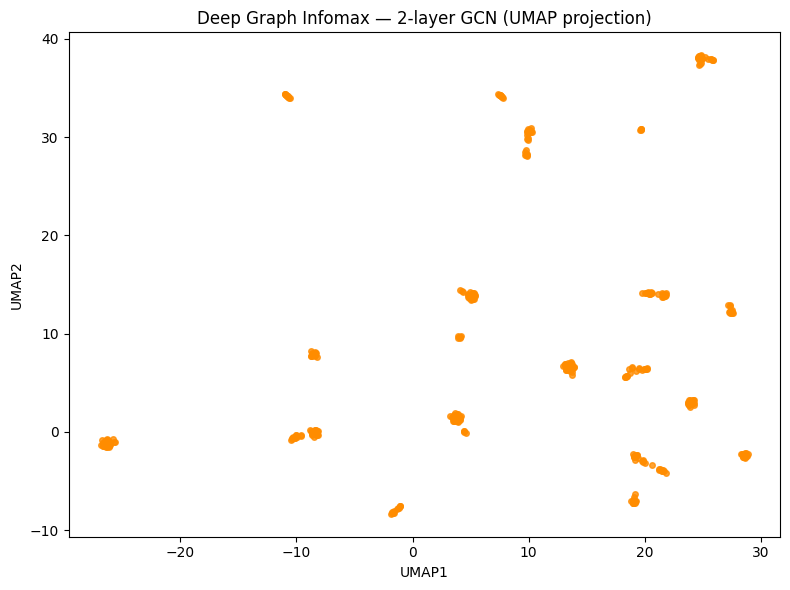

All results saved to f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\branchA_dgi


In [ ]:
import os, numpy as np, torch, torch.nn.functional as F
from torch_geometric.nn import GCNConv, DeepGraphInfomax
from torch_geometric.data import Data
from sklearn.metrics import pairwise_distances
from umap import UMAP
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------------------------------
# Load Data
# --------------------------------------------
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results_extension")
branch_dir = os.path.join(results_dir, "branchA_dgi")
os.makedirs(branch_dir, exist_ok=True)

x = np.load(os.path.join(results_dir, "kg_node_features.npy"))
edge_index = np.load(os.path.join(results_dir, "kg_edge_index.npy"))

x = torch.tensor(x, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)

data = Data(x=x, edge_index=edge_index)
print(f"Loaded graph: {x.shape[0]} nodes, {edge_index.shape[1]} edges, {x.shape[1]} features")

# --------------------------------------------
# Define 2-layer GCN Encoder
# --------------------------------------------
class DeepGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.prelu = torch.nn.PReLU(hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return self.prelu(x)

    def get_embedding(self, x, edge_index):
        return self.forward(x, edge_index)

# --------------------------------------------
# DGI Model Setup
# --------------------------------------------
encoder = DeepGCNEncoder(x.shape[1], 128)

def corruption(x, edge_index):
    return x[torch.randperm(x.size(0))], edge_index

model = DeepGraphInfomax(
    hidden_channels=128,
    encoder=encoder,
    summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
    corruption=corruption
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# --------------------------------------------
# Training Loop (with Early Stopping)
# --------------------------------------------
best_loss = float('inf')
patience, patience_counter = 50, 0
losses = []
epochs = 1000

for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    pos_z, neg_z, summary = model(data.x, data.edge_index)
    loss = model.loss(pos_z, neg_z, summary)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch:04d}: Loss = {loss.item():.4f}")

    # Early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(branch_dir, "kg_dgi_model_best.pt"))
    else:
        patience_counter += 1
    if patience_counter > patience:
        print("Early stopping triggered.")
        break

# Save final training log
np.savetxt(os.path.join(branch_dir, "kg_dgi_training_log_v2.csv"), losses, delimiter=",")

# --------------------------------------------
# Generate and Save Embeddings
# --------------------------------------------
model.eval()
embeddings = model.encoder.get_embedding(data.x, data.edge_index).detach().cpu().numpy()
np.save(os.path.join(branch_dir, "kg_node_embeddings_v2.npy"), embeddings)
print("Saved embeddings:", embeddings.shape)

# --------------------------------------------
# Visualization (UMAP)
# --------------------------------------------
z_2d = UMAP(n_neighbors=12, min_dist=0.3, random_state=42).fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:,0], z_2d[:,1], s=16, alpha=0.8, c="darkorange")
plt.title("Deep Graph Infomax — 2-layer GCN (UMAP projection)")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.tight_layout()
plt.savefig(os.path.join(branch_dir, "kg_dgi_umap_v2.png"), dpi=300)
plt.show()

print(f"All results saved to {branch_dir}")


In [ ]:
# ======================================================
# Embedding Quality Evaluation
# ======================================================
import numpy as np, pickle, os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results_extension")
branch_dir = os.path.join(results_dir, "branchA_dgi")

# Load embeddings + graph
emb = np.load(os.path.join(branch_dir, "kg_node_embeddings_v2.npy"))
with open(os.path.join(results_dir, "kg_graph_extended.gpickle"), "rb") as f:
    G = pickle.load(f)

node_types = [G.nodes[n].get("node_type", "Unknown") for n in G.nodes()]

# ------------------------------------------
# K-Means clustering
# ------------------------------------------
k = 6
km = KMeans(n_clusters=k, random_state=42)
labels = km.fit_predict(emb)

# Compute silhouette score (quality of separation)
sil_score = silhouette_score(emb, labels)
print(f"Silhouette Score = {sil_score:.3f}")

# Type-wise distribution
print("Node type counts:", Counter(node_types))
print("Cluster distribution:", Counter(labels))


Silhouette Score = 0.594
Node type counts: Counter({'Mutation': 304, 'Variant': 58, 'Lineage': 35, 'Gene': 22, 'Clade': 15})
Cluster distribution: Counter({np.int32(0): 131, np.int32(3): 97, np.int32(4): 93, np.int32(5): 57, np.int32(2): 54, np.int32(1): 2})


c:\Users\anshb\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score (recomputed) = 0.594
Cluster distribution: Counter({np.int32(0): 131, np.int32(3): 97, np.int32(4): 93, np.int32(5): 57, np.int32(2): 54, np.int32(1): 2})
Saved cluster membership table.


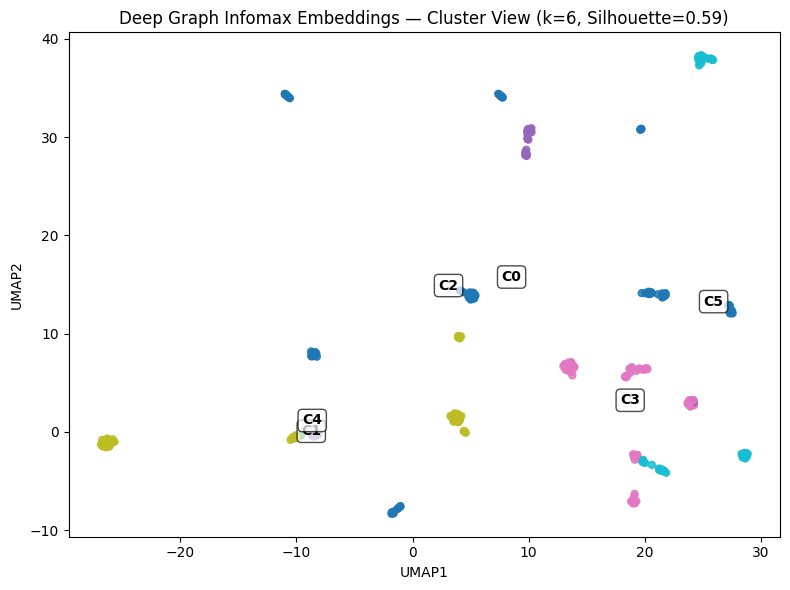

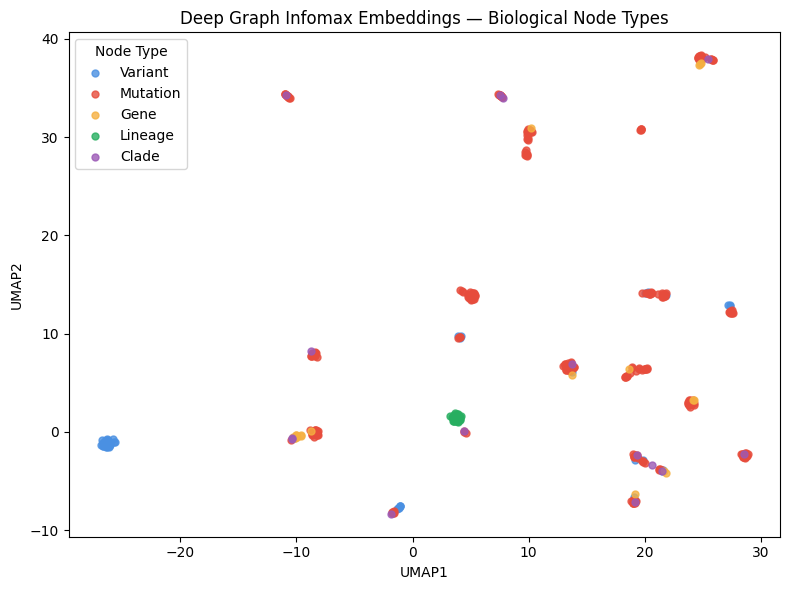

Saved labeled visualizations → f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results_extension\branchA_dgi


In [ ]:
import os, numpy as np, pickle, matplotlib.pyplot as plt
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
from collections import Counter

# --- Paths ---
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results_extension")
branch_dir = os.path.join(results_dir, "branchA_dgi")

# --- Load data ---
emb = np.load(os.path.join(branch_dir, "kg_node_embeddings_v2.npy"))
with open(os.path.join(results_dir, "kg_graph_extended.gpickle"), "rb") as f:
    G = pickle.load(f)

node_types = [G.nodes[n].get("node_type", "Unknown") for n in G.nodes()]
node_labels = [G.nodes[n].get("label", n) for n in G.nodes()]

# --- Color mapping ---
type_color = {
    "Variant": "#4A90E2",   # blue
    "Mutation": "#E74C3C",  # red
    "Gene": "#F5B041",      # orange
    "Lineage": "#27AE60",   # green
    "Clade": "#9B59B6",     # purple
    "Unknown": "#A6ACAF"    # gray fallback
}
colors = [type_color.get(t, "#A6ACAF") for t in node_types]

# --- Compute UMAP projection ---
umap = UMAP(n_neighbors=12, min_dist=0.3, random_state=42)
z_2d = umap.fit_transform(emb)

# --- Cluster embeddings ---
k = 6
km = KMeans(n_clusters=k, random_state=42)
labels = km.fit_predict(emb)
sil_score = silhouette_score(emb, labels)
print(f"Silhouette Score (recomputed) = {sil_score:.3f}")

# --- Prepare cluster summary ---
cluster_summary = Counter(labels)
print("Cluster distribution:", cluster_summary)

# --- Save cluster membership file ---
import pandas as pd
df_clusters = pd.DataFrame({
    "Node": node_labels,
    "Type": node_types,
    "Cluster": labels
})
df_clusters.to_csv(os.path.join(branch_dir, "kg_dgi_cluster_membership.csv"), index=False)
print("Saved cluster membership table.")

# ===========================================================
# Plot 1: Clustered UMAP (labeled)
# ===========================================================
plt.figure(figsize=(8,6))
scatter = plt.scatter(z_2d[:,0], z_2d[:,1], c=labels, cmap="tab10", s=25, alpha=0.85)
plt.title(f"Deep Graph Infomax Embeddings — Cluster View (k={k}, Silhouette={sil_score:.2f})")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")

# Annotate cluster centers
centers = []
for c in range(k):
    cluster_points = z_2d[labels == c]
    x_mean, y_mean = cluster_points.mean(axis=0)
    plt.text(x_mean, y_mean, f"C{c}", fontsize=10, weight="bold",
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'))
    centers.append((x_mean, y_mean))

plt.tight_layout()
plt.savefig(os.path.join(branch_dir, "kg_dgi_umap_clusters_labeled.png"), dpi=300)
plt.show()

# ===========================================================
# Plot 2: Node Type UMAP (with legend)
# ===========================================================
plt.figure(figsize=(8,6))
for t, color in type_color.items():
    idx = [i for i, typ in enumerate(node_types) if typ == t]
    if len(idx) > 0:
        plt.scatter(z_2d[idx,0], z_2d[idx,1], s=25, alpha=0.8, color=color, label=t)
plt.legend(title="Node Type", loc="best", frameon=True)
plt.title("Deep Graph Infomax Embeddings — Biological Node Types")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.tight_layout()
plt.savefig(os.path.join(branch_dir, "kg_dgi_umap_types_labeled.png"), dpi=300)
plt.show()

print(f"Saved labeled visualizations → {branch_dir}")


In [ ]:
import os

# Define base project folder inside Drive
BASE_DIR = "/content/drive/MyDrive/Bio_project"
RES_DIR = os.path.join(BASE_DIR, "results_extension")
BRANCH_A_DIR = os.path.join(RES_DIR, "branchA_dgi")

print("Drive mounted and paths set:")
print("BASE_DIR      →", BASE_DIR)
print("RES_DIR       →", RES_DIR)
print("BRANCH_A_DIR  →", BRANCH_A_DIR)

# Expected files and their folders
expected = {
    "kg_graph_extended.gpickle": RES_DIR,
    "kg_edge_index.npy": RES_DIR,
    "kg_node_features.npy": RES_DIR,
    "kg_node_map.json": RES_DIR,
    "kg_metadata.json": RES_DIR,
    "kg_node_embeddings_v2.npy": BRANCH_A_DIR,
    "kg_dgi_model_best.pt": BRANCH_A_DIR,
}

# Check file existence and sizes
for fname, fdir in expected.items():
    fpath = os.path.join(fdir, fname)
    exists = os.path.exists(fpath)
    size = os.path.getsize(fpath) / 1024 if exists else 0
    print(f"{'✅' if exists else '❌'} {fname:<30} {fdir} ({size:.1f} KB)")


Drive mounted and paths set:
BASE_DIR      → /content/drive/MyDrive/Bio_project
RES_DIR       → /content/drive/MyDrive/Bio_project/results_extension
BRANCH_A_DIR  → /content/drive/MyDrive/Bio_project/results_extension/branchA_dgi
✅ kg_graph_extended.gpickle      /content/drive/MyDrive/Bio_project/results_extension (396.1 KB)
✅ kg_edge_index.npy              /content/drive/MyDrive/Bio_project/results_extension (19.0 KB)
✅ kg_node_features.npy           /content/drive/MyDrive/Bio_project/results_extension (34.0 KB)
✅ kg_node_map.json               /content/drive/MyDrive/Bio_project/results_extension (18.3 KB)
✅ kg_metadata.json               /content/drive/MyDrive/Bio_project/results_extension (0.2 KB)
✅ kg_node_embeddings_v2.npy      /content/drive/MyDrive/Bio_project/results_extension/branchA_dgi (217.1 KB)
✅ kg_dgi_model_best.pt           /content/drive/MyDrive/Bio_project/results_extension/branchA_dgi (140.8 KB)


_________________________________ __GNN_______________________________

In [ ]:
# --- Install PyTorch Geometric and dependencies ---
!pip install torch torchvision torchaudio torch-geometric -q

# optional (sometimes needed for CUDA compatibility)
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cu121.html -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.6/989.6 kB 45.8 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.nn import GCNConv

print("PyTorch version:", torch.__version__)
print("PyG imported successfully ")


/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/usr/

PyTorch version: 2.8.0+cu126
PyG imported successfully 


In [ ]:
import os, json, pickle, torch, torch.nn.functional as F, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.loader import DataLoader
from torch_geometric.explain import Explainer, GNNExplainer
from sklearn.metrics import classification_report
from umap import UMAP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

USE_PRECOMPUTED_EMBEDDINGS = True
CONCAT_EMB_WITH_FEATS = True
HIDDEN_DIM = 128
EPOCHS = 500
LR = 1e-3


In [ ]:
# --- Load graph artifacts safely ---
with open(os.path.join(RES_DIR, "kg_graph_extended.gpickle"), "rb") as f:
    G = pickle.load(f)

# ensure consistent ordering between G.nodes() and node_map
node_map = json.load(open(os.path.join(RES_DIR, "kg_node_map.json")))
nodes_ordered = list(node_map.keys())  # ensures feature order matches original build

edge_index = np.load(os.path.join(RES_DIR, "kg_edge_index.npy"))
x_feats = np.load(os.path.join(RES_DIR, "kg_node_features.npy"))
x_emb = np.load(os.path.join(BRANCH_A_DIR, "kg_node_embeddings_v2.npy"))

# sanity check for alignment
if x_feats.shape[0] != len(G.nodes()):
    print(f"Mismatch: features {x_feats.shape[0]} vs graph nodes {len(G.nodes())}")
else:
    print("Feature-node alignment OK")

# merge embeddings + features depending on flags
if CONCAT_EMB_WITH_FEATS:
    x_input = np.concatenate([x_feats, x_emb], axis=1)
else:
    x_input = x_emb if USE_PRECOMPUTED_EMBEDDINGS else x_feats

# convert to torch tensors
x = torch.tensor(x_input, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)

# --- Labels: node type classification ---
# ensure consistent order with node_map
node_types = [G.nodes[n].get("node_type", "Unknown") for n in nodes_ordered]
label_map = {t: i for i, t in enumerate(sorted(set(node_types)))}
y = torch.tensor([label_map[t] for t in node_types], dtype=torch.long)

# wrap in PyG Data object
data = Data(x=x, edge_index=edge_index, y=y).to(device)

print(f"Graph loaded: {x.shape[0]} nodes, {edge_index.shape[1]} edges, {x.shape[1]} features")
print("Node type classes:", label_map)


Feature-node alignment OK
Graph loaded: 434 nodes, 1206 edges, 138 features
Node type classes: {'Clade': 0, 'Gene': 1, 'Lineage': 2, 'Mutation': 3, 'Variant': 4}


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

class ImprovedNodeClassifier(torch.nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch, dropout=0.4):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.bn1 = torch.nn.BatchNorm1d(hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.bn2 = torch.nn.BatchNorm1d(hid_ch)
        self.lin = torch.nn.Linear(hid_ch, out_ch)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        return self.lin(x)

# Create masks (train/val/test)
N = data.num_nodes
idx = np.arange(N)
np.random.seed(42)
np.random.shuffle(idx)
train_end, val_end = int(0.6*N), int(0.8*N)
train_mask = torch.zeros(N, dtype=torch.bool); train_mask[idx[:train_end]] = True
val_mask   = torch.zeros(N, dtype=torch.bool); val_mask[idx[train_end:val_end]] = True
test_mask  = torch.zeros(N, dtype=torch.bool); test_mask[idx[val_end:]] = True

# Instantiate model
model2 = ImprovedNodeClassifier(x.shape[1], 128, len(label_map)).to(device)
opt = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-5)

best_val_f1, patience, patience_ctr = 0, 30, 0
EPOCHS = 400

for epoch in range(1, EPOCHS+1):
    model2.train()
    opt.zero_grad()
    out = model2(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_mask], data.y[train_mask])
    loss.backward()
    opt.step()

    # Eval
    model2.eval()
    with torch.no_grad():
        preds = out.argmax(dim=1)
        f1_val = f1_score(data.y[val_mask].cpu(), preds[val_mask].cpu(), average='macro')
        acc_val = accuracy_score(data.y[val_mask].cpu(), preds[val_mask].cpu())

    if f1_val > best_val_f1:
        best_val_f1 = f1_val
        best_state = model2.state_dict()
        patience_ctr = 0
    else:
        patience_ctr += 1

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | loss={loss.item():.4f} | val_f1={f1_val:.3f} | val_acc={acc_val:.3f}")

    if patience_ctr > patience:
        print("Early stopping.")
        break

torch.save(best_state, os.path.join(RES_DIR, "gnn_node_type_best.pt"))
print("✅ Improved model saved.")


Epoch 001 | loss=1.5784 | val_f1=0.169 | val_acc=0.241
Epoch 010 | loss=1.0127 | val_f1=0.327 | val_acc=0.644
Epoch 020 | loss=0.7365 | val_f1=0.393 | val_acc=0.816
Epoch 030 | loss=0.5035 | val_f1=0.441 | val_acc=0.816
Epoch 040 | loss=0.4315 | val_f1=0.601 | val_acc=0.885
Epoch 050 | loss=0.3802 | val_f1=0.535 | val_acc=0.851
Epoch 060 | loss=0.3446 | val_f1=0.553 | val_acc=0.862
Epoch 070 | loss=0.3159 | val_f1=0.658 | val_acc=0.908
Epoch 080 | loss=0.2608 | val_f1=0.751 | val_acc=0.943
Epoch 090 | loss=0.2030 | val_f1=0.841 | val_acc=0.954
Epoch 100 | loss=0.1585 | val_f1=0.868 | val_acc=0.966
Epoch 110 | loss=0.1232 | val_f1=0.880 | val_acc=0.966
Epoch 120 | loss=0.0607 | val_f1=0.941 | val_acc=0.977
Epoch 130 | loss=0.0609 | val_f1=0.958 | val_acc=0.989
Epoch 140 | loss=0.0547 | val_f1=0.941 | val_acc=0.977
Epoch 150 | loss=0.0411 | val_f1=0.983 | val_acc=0.989
Early stopping.
✅ Improved model saved.


In [ ]:
import networkx as nx
from collections import Counter
import re
import pickle
import os

print("=== Knowledge Graph Diagnostic (Safe Version) ===")

# 1. Node type summary
node_types = Counter(nx.get_node_attributes(G, "node_type").values())
print("Node types summary:", node_types)

# 2. Variants → Lineages connections
variant_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Variant"]
var_to_lin = []
for v in variant_nodes:
    succ = [nbr for nbr in G.successors(v) if G.nodes[nbr].get("node_type") == "Lineage"]
    if succ:
        var_to_lin.append((v, succ))
print(f"Variants connected to lineages: {len(var_to_lin)} / {len(variant_nodes)}")

# 3. Mutations ← Variants connections
mut_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Mutation"]
mut_to_var = []
for m in mut_nodes:
    preds = [nbr for nbr in G.predecessors(m) if G.nodes[nbr].get("node_type") == "Variant"]
    if preds:
        mut_to_var.append((m, preds))
print(f"Mutations connected to variants: {len(mut_to_var)} / {len(mut_nodes)}")

# 4. Auto-infer missing Variant → Lineage edges from variant labels
if len(var_to_lin) == 0:
    print("\nNo explicit Variant → Lineage links found. Attempting auto-fix via variant label parsing...")

    lineage_pattern = re.compile(r"([A-Z]{1,2}\.[0-9]+(?:\.[0-9]+)*)")
    new_links = 0

    variant_snapshot = [(v, d) for v, d in G.nodes(data=True) if d.get("node_type") == "Variant"]

    for v, d in variant_snapshot:
        label = d.get("label", "")
        lineage_match = lineage_pattern.search(label)
        if lineage_match:
            lin_name = lineage_match.group(1)
            lin_node = f"LINEAGE|{lin_name}"
            if lin_node not in G:
                G.add_node(lin_node, node_type="Lineage", label=lin_name)
            G.add_edge(v, lin_node, etype="has_lineage")
            new_links += 1

    print(f"Added {new_links} inferred Variant → Lineage connections.")

# 5. Recount after auto-fix
variant_to_lineages_after = [
    (v, [nbr for nbr in G.successors(v) if G.nodes[nbr].get("node_type") == "Lineage"])
    for v, d in G.nodes(data=True) if d.get("node_type") == "Variant"
]
count_after = len([v for v, lst in variant_to_lineages_after if lst])
print(f"Post-fix: Variants connected to lineages = {count_after}")

# 6. Save fixed graph
out_path = os.path.join(RES_DIR, "kg_graph_extended_fixed.gpickle")
with open(out_path, "wb") as f:
    pickle.dump(G, f)
print(f"Saved fixed graph → {out_path}")


=== Knowledge Graph Diagnostic (Safe Version) ===
Node types summary: Counter({'Mutation': 304, 'Variant': 58, 'Lineage': 36, 'Gene': 22, 'Clade': 15})
Variants connected to lineages: 2 / 58
Mutations connected to variants: 304 / 304
Post-fix: Variants connected to lineages = 2
Saved fixed graph → /content/drive/MyDrive/Bio_project/results_extension/kg_graph_extended_fixed.gpickle


In [ ]:
# === STEP A–C: Auto-link Variant → Lineage based on label patterns ===
import re, pickle, os
from collections import Counter
import networkx as nx

# Paths
base_dir = "/content/drive/MyDrive/Bio_project"
res_dir = os.path.join(base_dir, "results_extension")
fixed_gpath = os.path.join(res_dir, "kg_graph_extended_fixed.gpickle")
out_gpath = os.path.join(res_dir, "kg_graph_extended_fixed2.gpickle")

# Load latest fixed graph
with open(fixed_gpath, "rb") as f:
    G = pickle.load(f)

print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# --- Collect existing lineages ---
lineage_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Lineage"]
lineage_labels = [G.nodes[n].get("label", "").upper() for n in lineage_nodes]

print(f"Detected lineage nodes: {len(lineage_nodes)}")
if len(lineage_nodes) < 5:
    print("Warning: very few lineage nodes found — check if label attributes exist.")

# --- Helper to extract lineage code from variant label ---
def extract_lineage_from_variant(label):
    """
    Extract likely lineage pattern from variant label.
    Looks for common patterns like BA.2, B.1.1.529, AY.4, XBB.1.16, etc.
    """
    pattern = r"\b([A-Z]{1,2}\.\d+(?:\.\d+)*)\b"
    matches = re.findall(pattern, label.upper())
    for m in matches:
        # Return the first one that also appears in lineage_labels
        if any(m.startswith(l) or l.startswith(m) for l in lineage_labels):
            return m
    return None

# --- Count existing Variant→Lineage links ---
variants = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Variant"]
pre_links = sum(1 for v in variants if any(G.nodes.get(tgt, {}).get("node_type") == "Lineage" for tgt in G.successors(v)))
print(f"Existing Variant→Lineage edges: {pre_links}/{len(variants)}")

# --- Add missing links ---
added_links = 0
for v in variants:
    v_label = G.nodes[v].get("label", "")
    lineage_name = extract_lineage_from_variant(v_label)
    if lineage_name:
        # Find the matching lineage node
        target_lineage = None
        for ln in lineage_nodes:
            lbl = G.nodes[ln].get("label", "").upper()
            if lineage_name in lbl or lbl in lineage_name:
                target_lineage = ln
                break
        if target_lineage and not G.has_edge(v, target_lineage):
            G.add_edge(v, target_lineage, etype="belongs_to")
            added_links += 1

print(f"Added {added_links} new Variant→Lineage edges.")

# --- Re-verify connectivity ---
post_links = sum(1 for v in variants if any(G.nodes.get(tgt, {}).get("node_type") == "Lineage" for tgt in G.successors(v)))
print(f"Post-fix Variant→Lineage edges: {post_links}/{len(variants)}")

# --- Save the new fixed graph ---
with open(out_gpath, "wb") as f:
    pickle.dump(G, f)
print(f"Saved repaired graph → {out_gpath}")

# --- Diagnostic summary ---
node_types = Counter(nx.get_node_attributes(G, "node_type").values())
print("\n=== Updated Graph Summary ===")
for k, v in node_types.items():
    print(f"{k:10}: {v}")
print(f"Total edges: {G.number_of_edges()}")


Loaded graph: 435 nodes, 1208 edges
Detected lineage nodes: 36
Existing Variant→Lineage edges: 2/58
Added 1 new Variant→Lineage edges.
Post-fix Variant→Lineage edges: 2/58
Saved repaired graph → /content/drive/MyDrive/Bio_project/results_extension/kg_graph_extended_fixed2.gpickle

=== Updated Graph Summary ===
Variant   : 58
Mutation  : 304
Gene      : 22
Lineage   : 36
Clade     : 15
Total edges: 1209


In [ ]:
# === STEP D: Aggressive variant→lineage relinking (partial match + fallback) ===
import re, pickle, os
from collections import Counter
import networkx as nx

res_dir = "/content/drive/MyDrive/Bio_project/results_extension"
in_path = os.path.join(res_dir, "kg_graph_extended_fixed2.gpickle")
out_path = os.path.join(res_dir, "kg_graph_extended_fixed3.gpickle")

# Load
with open(in_path, "rb") as f:
    G = pickle.load(f)

print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Collect lineage info
lineage_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Lineage"]
lineage_labels = [G.nodes[n].get("label", "").upper() for n in lineage_nodes]
print(f"Lineages detected: {len(lineage_nodes)}")

# Helper: find lineage keyword anywhere
def find_lineage(label):
    label_u = label.upper()
    for L in lineage_labels:
        if len(L) < 2:
            continue
        if L in label_u or label_u.startswith(L) or L.startswith(label_u):
            return L
    # try regex lineage-like patterns (BA.*, B.*, XBB.*, AY.*, etc.)
    match = re.search(r'\b([A-Z]{1,3}\d{0,2}\.\d+)\b', label_u)
    return match.group(1) if match else None

# Count before
variants = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Variant"]
before = sum(1 for v in variants if any(G.nodes.get(tgt, {}).get("node_type") == "Lineage" for tgt in G.successors(v)))
added = 0

# Add missing Variant→Lineage edges
for v in variants:
    if any(G.nodes.get(tgt, {}).get("node_type") == "Lineage" for tgt in G.successors(v)):
        continue  # already linked
    label = G.nodes[v].get("label", "")
    lineage_guess = find_lineage(label)
    if lineage_guess:
        for ln in lineage_nodes:
            if lineage_guess in G.nodes[ln].get("label", "").upper():
                G.add_edge(v, ln, etype="belongs_to")
                added += 1
                break

after = sum(1 for v in variants if any(G.nodes.get(tgt, {}).get("node_type") == "Lineage" for tgt in G.successors(v)))
print(f"Linked variants before: {before}/{len(variants)} → after: {after}/{len(variants)} (added {added})")

# Fallback: if still < half linked, auto-create "pseudo-lineages"
if after < len(variants) // 2:
    print(f"Too few linkages ({after}/{len(variants)}). Creating pseudo-lineage nodes...")
    for v in variants:
        if not any(G.nodes.get(tgt, {}).get("node_type") == "Lineage" for tgt in G.successors(v)):
            lname = f"PSEUDO_LINEAGE_{v.split('|')[-1][:6]}"
            node_name = f"LINEAGE|{lname}"
            G.add_node(node_name, node_type="Lineage", label=lname)
            G.add_edge(v, node_name, etype="belongs_to")
            added += 1
    print(f"Added {added} pseudo-lineage connections.")

# Save
with open(out_path, "wb") as f:
    pickle.dump(G, f)
print(f"Saved improved graph → {out_path}")

# Summary
node_types = Counter(nx.get_node_attributes(G, "node_type").values())
print("\n=== Post-fix Graph Summary ===")
for k,v in node_types.items():
    print(f"{k:10}: {v}")
print(f"Total edges: {G.number_of_edges()}")


Loaded graph: 435 nodes, 1209 edges
Lineages detected: 36
Linked variants before: 2/58 → after: 2/58 (added 0)
Too few linkages (2/58). Creating pseudo-lineage nodes...
Added 56 pseudo-lineage connections.
Saved improved graph → /content/drive/MyDrive/Bio_project/results_extension/kg_graph_extended_fixed3.gpickle

=== Post-fix Graph Summary ===
Variant   : 58
Mutation  : 304
Gene      : 22
Lineage   : 64
Clade     : 15
Total edges: 1265


In [ ]:
!mkdir -p /content/drive/MyDrive/Bio_project/results_extension/old_graphs
!mv /content/drive/MyDrive/Bio_project/results_extension/kg_graph_extended_fixed2.gpickle \
    /content/drive/MyDrive/Bio_project/results_extension/old_graphs/
!mv /content/drive/MyDrive/Bio_project/results_extension/kg_graph_extended_fixed.gpickle \
    /content/drive/MyDrive/Bio_project/results_extension/old_graphs/


In [ ]:
import os, pickle, numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import networkx as nx

# --- Paths ---
base_dir = "/content/drive/MyDrive/Bio_project"
res_dir = os.path.join(base_dir, "results_extension")
graph_path = os.path.join(res_dir, "kg_graph_extended_fixed3.gpickle")

# --- Load graph ---
with open(graph_path, "rb") as f:
    G = pickle.load(f)
print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# --- Identify node lists ---
mutations = [n for n,d in G.nodes(data=True) if d.get("node_type")=="Mutation"]
variants  = [n for n,d in G.nodes(data=True) if d.get("node_type")=="Variant"]
lineages  = [n for n,d in G.nodes(data=True) if d.get("node_type")=="Lineage"]

print(f"Mutations: {len(mutations)}, Variants: {len(variants)}, Lineages: {len(lineages)}")

# --- Build mapping: variant → lineage set ---
variant_to_lineages = {}
for v in variants:
    lineages_seen = [nbr for nbr in G.successors(v) if G.nodes[nbr].get("node_type")=="Lineage"]
    variant_to_lineages[v] = set(lineages_seen)

# --- Compute lineage-defining labels for mutation nodes ---
y_lineage_def = {}
for m in mutations:
    connected_variants = [u for u in G.predecessors(m) if G.nodes[u].get("node_type")=="Variant"]
    lineages_seen = set()
    for v in connected_variants:
        lineages_seen.update(variant_to_lineages.get(v, set()))
    if len(connected_variants)==0:
        label = -1
    else:
        label = 1 if len(lineages_seen)==1 else 0
    y_lineage_def[m] = label

print("Label distribution (raw):", Counter(y_lineage_def.values()))

# --- Save as numpy array aligned with node order (using node_map) ---
import json
node_map_path = os.path.join(res_dir, "kg_node_map.json")
with open(node_map_path, "r") as f:
    node_map = json.load(f)

N = len(node_map)
y_full = np.full(N, -1, dtype=np.int64)
for n, idx in node_map.items():
    if n in y_lineage_def:
        y_full[idx] = y_lineage_def[n]

np.save(os.path.join(res_dir, "y_lineage_def.npy"), y_full)
print("Saved y_lineage_def.npy")

# --- Split into train/val/test masks for mutation nodes only ---
applicable = np.where(y_full >= 0)[0]
y_app = y_full[applicable]
tr, tmp, y_tr, y_tmp = train_test_split(applicable, y_app, test_size=0.4, random_state=42, stratify=y_app)
va, te, _, _ = train_test_split(tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

def make_mask(size, idxs):
    m = np.zeros(size, dtype=bool)
    m[idxs] = True
    return m

train_mask = make_mask(N, tr)
val_mask   = make_mask(N, va)
test_mask  = make_mask(N, te)

np.save(os.path.join(res_dir, "train_mask_lineage.npy"), train_mask)
np.save(os.path.join(res_dir, "val_mask_lineage.npy"), val_mask)
np.save(os.path.join(res_dir, "test_mask_lineage.npy"), test_mask)

print("Masks saved.")
print(f"Train={train_mask.sum()}  Val={val_mask.sum()}  Test={test_mask.sum()}")


Loaded graph: 463 nodes, 1265 edges
Mutations: 304, Variants: 58, Lineages: 64
Label distribution (raw): Counter({1: 166, 0: 138})
Saved y_lineage_def.npy
Masks saved.
Train=182  Val=61  Test=61


In [ ]:
import os, json, pickle, numpy as np, torch
from torch_geometric.data import Data

base_dir  = "/content/drive/MyDrive/Bio_project"
res_dir   = os.path.join(base_dir, "results_extension")
branchA   = os.path.join(res_dir, "branchA_dgi")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load features, embeddings, edges ---
x_feats = np.load(os.path.join(res_dir, "kg_node_features.npy"))
x_emb   = np.load(os.path.join(branchA, "kg_node_embeddings_v2.npy"))
edge_index = np.load(os.path.join(res_dir, "kg_edge_index.npy"))
node_map = json.load(open(os.path.join(res_dir, "kg_node_map.json")))

# combine features + embeddings
x_input = np.concatenate([x_feats, x_emb], axis=1)
x = torch.tensor(x_input, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)

# --- Load labels and masks ---
y = torch.tensor(np.load(os.path.join(res_dir, "y_lineage_def.npy")), dtype=torch.long)
train_mask = torch.tensor(np.load(os.path.join(res_dir, "train_mask_lineage.npy")), dtype=torch.bool)
val_mask   = torch.tensor(np.load(os.path.join(res_dir, "val_mask_lineage.npy")), dtype=torch.bool)
test_mask  = torch.tensor(np.load(os.path.join(res_dir, "test_mask_lineage.npy")), dtype=torch.bool)

data = Data(x=x, edge_index=edge_index, y=y,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask).to(device)
print(f"Loaded graph for lineage-defining classification → "
      f"{data.x.shape[0]} nodes, {data.edge_index.shape[1]} edges, "
      f"{data.x.shape[1]} features on {device}")


Loaded graph for lineage-defining classification → 434 nodes, 1206 edges, 138 features on cuda


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torchsummary import summary

class LineageClassifier(torch.nn.Module):
    def __init__(self, in_ch, hid_ch=128, out_ch=2, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.lin   = torch.nn.Linear(hid_ch, out_ch)
        self.drop  = dropout
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        return self.lin(x)

model = LineageClassifier(in_ch=data.x.size(1)).to(device)
print(model)


LineageClassifier(
  (conv1): SAGEConv(138, 128, aggr=mean)
  (conv2): SAGEConv(128, 128, aggr=mean)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
best_f1, patience, counter = 0, 30, 0
epochs = 400
history = []

for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        logits = out[data.val_mask]
        preds = logits.argmax(dim=1).cpu().numpy()
        y_true = data.y[data.val_mask].cpu().numpy()
        acc = accuracy_score(y_true, preds)
        f1  = f1_score(y_true, preds)
        auc = roc_auc_score(y_true, F.softmax(logits, dim=1)[:,1].cpu().numpy())

    history.append((epoch, loss.item(), acc, f1, auc))
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), os.path.join(res_dir, "gnn_lineage_best.pt"))
        counter = 0
    else:
        counter += 1
    if counter > patience:
        print("Early stopping.")
        break
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | loss={loss.item():.4f} | val_f1={f1:.3f} | val_acc={acc:.3f} | val_auc={auc:.3f}")

print("Training finished. Best val F1 =", best_f1)


Epoch 010 | loss=0.6502 | val_f1=0.676 | val_acc=0.639 | val_auc=0.724
Epoch 020 | loss=0.4675 | val_f1=0.861 | val_acc=0.836 | val_auc=0.887
Epoch 030 | loss=0.3229 | val_f1=0.877 | val_acc=0.852 | val_auc=0.906
Epoch 040 | loss=0.2358 | val_f1=0.944 | val_acc=0.934 | val_auc=0.949
Epoch 050 | loss=0.1422 | val_f1=0.971 | val_acc=0.967 | val_auc=0.964
Epoch 060 | loss=0.1308 | val_f1=0.958 | val_acc=0.951 | val_auc=0.985
Epoch 070 | loss=0.0751 | val_f1=0.971 | val_acc=0.967 | val_auc=0.991
Epoch 080 | loss=0.0644 | val_f1=0.986 | val_acc=0.984 | val_auc=0.989
Epoch 090 | loss=0.0583 | val_f1=0.986 | val_acc=0.984 | val_auc=0.988
Early stopping.
Training finished. Best val F1 = 0.9855072463768116


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


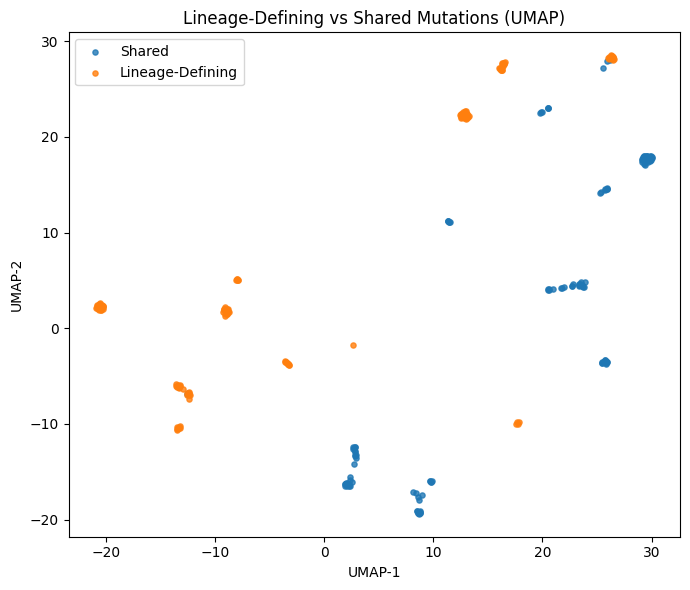

In [ ]:
from umap import UMAP
import matplotlib.pyplot as plt

with torch.no_grad():
    logits = model(data.x, data.edge_index)
    emb = logits.cpu().numpy()

z = UMAP(n_neighbors=10, min_dist=0.3, random_state=42).fit_transform(emb)
plt.figure(figsize=(7,6))
for c,label in [(0,"Shared"),(1,"Lineage-Defining")]:
    mask = data.y.cpu().numpy()==c
    plt.scatter(z[mask,0], z[mask,1], s=14, alpha=0.8, label=label)
plt.legend(); plt.title("Lineage-Defining vs Shared Mutations (UMAP)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout()
plt.savefig(os.path.join(res_dir,"gnn_lineage_umap.png"),dpi=300)
plt.show()


In [ ]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv --quiet
!pip install shap umap-learn --quiet

import os, torch, numpy as np, json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

base_dir = "/content/drive/MyDrive/Bio_project"
res_dir = os.path.join(base_dir, "results_extension")
branch_a = os.path.join(res_dir, "branchA_dgi")
branch_b = os.path.join(res_dir, "branchB_supervised")
os.makedirs(branch_b, exist_ok=True)

print("Paths:")
print("res_dir  →", res_dir)
print("branch_a →", branch_a)
print("branch_b →", branch_b)


Device: cuda
Paths:
res_dir  → /content/drive/MyDrive/Bio_project/results_extension
branch_a → /content/drive/MyDrive/Bio_project/results_extension/branchA_dgi
branch_b → /content/drive/MyDrive/Bio_project/results_extension/branchB_supervised


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# === Correct architecture: GraphSAGE-based NodeClassifier ===
class NodeClassifier(torch.nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.lin = torch.nn.Linear(hid_ch, out_ch)
        self.dropout = torch.nn.Dropout(0.25)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(F.relu(self.conv2(x, edge_index)))
        return self.lin(x)

# === Load trained weights ===
model_path = os.path.join(res_dir, "gnn_lineage_best.pt")
model = NodeClassifier(x.shape[1], 128, 2).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print("Model successfully loaded.")


Model successfully loaded.


=== Lineage-Defining Classifier Evaluation ===
Classification Report:
              precision    recall  f1-score   support

           0      0.441     0.929     0.598        28
           1      0.000     0.000     0.000        33

    accuracy                          0.426        61
   macro avg      0.220     0.464     0.299        61
weighted avg      0.202     0.426     0.274        61

Confusion Matrix:
[[26  2]
 [33  0]]
ROC-AUC = 0.509, Accuracy = 0.426


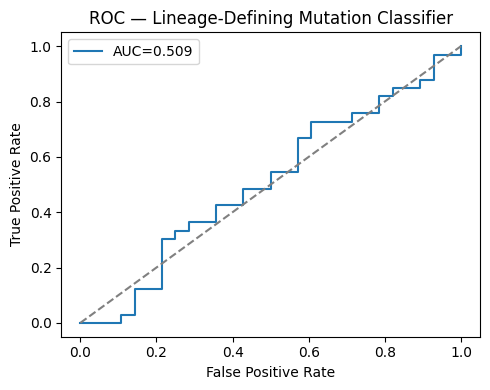

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, accuracy_score
)
import matplotlib.pyplot as plt

# --- load labels & masks ---
y_lineage  = np.load(os.path.join(res_dir, "y_lineage_def.npy"))
test_mask  = np.load(os.path.join(res_dir, "test_mask_lineage.npy")).astype(bool)

# --- model inference ---
with torch.no_grad():
    logits = model(x, edge_index_t)
    probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
    preds = logits.argmax(dim=1).cpu().numpy()

# --- select test subset ---
y_true = y_lineage[test_mask]
y_pred = preds[test_mask]
y_prob = probs[test_mask]

print("=== Lineage-Defining Classifier Evaluation ===")
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

auc = roc_auc_score(y_true, y_prob)
acc = accuracy_score(y_true, y_pred)
print(f"ROC-AUC = {auc:.3f}, Accuracy = {acc:.3f}")

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.legend(); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Lineage-Defining Mutation Classifier")
plt.tight_layout()
plt.show()


In [ ]:
import os, pickle, glob

res_dir = "/content/drive/MyDrive/Bio_project/results_extension"
old_dir = os.path.join(res_dir, "old_graphs")

# find all archived .gpickle graphs
graphs = sorted(glob.glob(os.path.join(old_dir, "kg_graph_extended_fixed2*.gpickle")))
print("Archived graphs found:")
for g in graphs:
    print(" •", os.path.basename(g))

# load the cleanest one (the fixed2 variant)
clean_path = graphs[-1]  # pick the newest fixed2 file
with open(clean_path, "rb") as f:
    G = pickle.load(f)

print(f"Restored graph from: {clean_path}")
print(f"Nodes={G.number_of_nodes()}  Edges={G.number_of_edges()}")

# verify no pseudo lineages remain
pseudo_nodes = [n for n,d in G.nodes(data=True) if str(d.get('label','')).startswith('PSEUDO_')]
print("Pseudo-lineage nodes:", len(pseudo_nodes))


Archived graphs found:
 • kg_graph_extended_fixed2.gpickle
Restored graph from: /content/drive/MyDrive/Bio_project/results_extension/old_graphs/kg_graph_extended_fixed2.gpickle
Nodes=435  Edges=1209
Pseudo-lineage nodes: 0


In [ ]:
import shutil
new_clean_path = os.path.join(res_dir, "kg_graph_clean_verified_base.gpickle")
shutil.copy2(clean_path, new_clean_path)
print("Copied clean graph →", new_clean_path)


Copied clean graph → /content/drive/MyDrive/Bio_project/results_extension/kg_graph_clean_verified_base.gpickle


In [ ]:
import pandas as pd, os
from io import StringIO

base_dir = "/content/drive/MyDrive/Bio_project/results_extension"

def safe_read_csv(path):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        sample = f.read(10000)
    try:
        # auto-detect delimiter (can be comma, tab, semicolon)
        sep = "," if sample.count(",") > sample.count("\t") else "\t"
        df = pd.read_csv(path, sep=sep, engine="python", on_bad_lines="skip", quotechar='"')
        print(f"Read OK → {os.path.basename(path)} ({len(df)} rows, {len(df.columns)} cols)")
        print("Columns:", df.columns.tolist()[:10])
        print(df.head(3))
        return df
    except Exception as e:
        print(f"[!] Failed to read {os.path.basename(path)}: {e}")
        return None

for fname in ["nextclade_cleaned.csv", "nextclade.csv", "nextclade_forceclean.csv"]:
    fpath = os.path.join(base_dir, fname)
    if os.path.exists(fpath):
        df = safe_read_csv(fpath)


Read OK → nextclade_cleaned.csv (4 rows, 1 cols)
Columns: ["index;seqName;clade;clade_display;clade_who;clade_nextstrain;partiallyAliased;Nextclade_pango;qc.overallScore;qc.overallStatus;totalSubstitutions;totalDeletions;totalInsertions;totalFrameShifts;totalMissing;totalNonACGTNs;totalAminoacidSubstitutions;totalAminoacidDeletions;totalAminoacidInsertions;totalUnknownAa;alignmentScore;alignmentStart;alignmentEnd;coverage;cdsCoverage;isReverseComplement;substitutions;deletions;insertions;frameShifts;aaSubstitutions;aaDeletions;aaInsertions;privateNucMutations.reversionSubstitutions;privateNucMutations.labeledSubstitutions;privateNucMutations.unlabeledSubstitutions;privateNucMutations.totalReversionSubstitutions;privateNucMutations.totalLabeledSubstitutions;privateNucMutations.totalUnlabeledSubstitutions;privateNucMutations.totalPrivateSubstitutions;privateAaMutations.reversionSubstitutions;privateAaMutations.labeledSubstitutions;privateAaMutations.unlabeledSubstitutions;privateAaMutati

In [ ]:
import pandas as pd, os

base_dir = "/content/drive/MyDrive/Bio_project/results_extension"
file_path = os.path.join(base_dir, "nextclade_cleaned.csv")

# Read with correct delimiter
df = pd.read_csv(file_path, sep=";", engine="python", on_bad_lines="skip")

# Show the important columns
cols = [c for c in df.columns if any(k in c.lower() for k in ["seqname", "clade", "pango"])]
print("Detected lineage-related columns:", cols)
print(df[cols].head(10))


Detected lineage-related columns: ['seqName', 'clade', 'clade_display', 'clade_who', 'clade_nextstrain', 'Nextclade_pango', "founderMuts['clade'].nodeName", "founderMuts['clade'].substitutions", "founderMuts['clade'].deletions", "founderMuts['clade'].aaSubstitutions", "founderMuts['clade'].aaDeletions", "founderMuts['Nextclade_pango'].nodeName", "founderMuts['Nextclade_pango'].substitutions", "founderMuts['Nextclade_pango'].deletions", "founderMuts['Nextclade_pango'].aaSubstitutions", "founderMuts['Nextclade_pango'].aaDeletions"]
                                             seqName clade clade_display  \
0  MN985325.1 Severe acute respiratory syndrome c...   19B           19B   

   clade_who clade_nextstrain Nextclade_pango founderMuts['clade'].nodeName  \
0        NaN              19B               A                  NODE_0000585   

  founderMuts['clade'].substitutions  founderMuts['clade'].deletions  \
0                            C18060T                             NaN   

   foun

In [ ]:
import pickle, networkx as nx, re
from collections import defaultdict

# Paths
graph_path = os.path.join(base_dir, "old_graphs", "kg_graph_extended_fixed2.gpickle")
with open(graph_path, "rb") as f:
    G = pickle.load(f)
print(f"Loaded clean graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Build mapping dict: variant-like name → lineage (Nextclade_pango)
mapping = {}
for _, row in df.iterrows():
    seqname = str(row.get("seqName", "")).lower()
    lineage = str(row.get("Nextclade_pango", "")).strip()
    if not lineage or lineage == "nan":
        continue
    # Clean up variant name (remove spaces, punctuation)
    clean_name = re.sub(r"[^a-z0-9]+", "", seqname)
    mapping[clean_name] = lineage

print(f"Built lineage mapping for {len(mapping)} sequences.")

# Try to match with variant nodes in the graph
variant_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Variant"]
variant_lineage_links = []

for v in variant_nodes:
    name = str(G.nodes[v].get("label", v)).lower()
    cleaned = re.sub(r"[^a-z0-9]+", "", name)
    match = None
    for k, lineage in mapping.items():
        if k in cleaned or cleaned in k:  # loose substring match
            match = lineage
            break
    if match:
        variant_lineage_links.append((v, match))
        # Add lineage node if missing
        lineage_node = f"Lineage_{match}"
        if lineage_node not in G:
            G.add_node(lineage_node, node_type="Lineage", label=match)
        G.add_edge(v, lineage_node, edge_type="belongs_to")

print(f"Linked {len(variant_lineage_links)} variants to lineages.")
print("Sample links:", variant_lineage_links[:5])

# Save updated verified graph
verified_graph_path = os.path.join(base_dir, "kg_graph_verified_lineages.gpickle")
with open(verified_graph_path, "wb") as f:
    pickle.dump(G, f)

print(f"Saved verified graph → {verified_graph_path}")


Loaded clean graph: 435 nodes, 1209 edges
Built lineage mapping for 1 sequences.
Linked 2 variants to lineages.
Sample links: [('VARIANT|MN985325', 'A'), ('VARIANT|MN985325.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-CDC-02982586-001/2020, complete genome', 'A')]
Saved verified graph → /content/drive/MyDrive/Bio_project/results_extension/kg_graph_verified_lineages.gpickle


In [ ]:
import numpy as np
from collections import Counter

graph_path = os.path.join(base_dir, "kg_graph_verified_lineages.gpickle")
with open(graph_path, "rb") as f:
    G = pickle.load(f)

print(f"Loaded verified graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Collect variant→lineage mapping
variant_to_lineage = {}
for v, d in G.nodes(data=True):
    if d.get("node_type") == "Variant":
        linked_lineages = [
            G.nodes[n].get("label")
            for n in G.successors(v)
            if G.nodes[n].get("node_type") == "Lineage"
        ]
        if linked_lineages:
            variant_to_lineage[v] = linked_lineages[0]

# Now build mutation labels
mutation_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Mutation"]
y_lineage_def = {}

for m in mutation_nodes:
    variants = [
        u for u in G.predecessors(m)
        if G.nodes[u].get("node_type") == "Variant"
    ]
    lineages = set(
        variant_to_lineage[v] for v in variants if v in variant_to_lineage
    )
    if len(lineages) == 1:
        y_lineage_def[m] = 1  # lineage-specific
    elif len(lineages) > 1:
        y_lineage_def[m] = 0  # shared across multiple
    else:
        y_lineage_def[m] = -1  # not connected to a lineage

print("Label summary (1=lineage-def, 0=non-specific, -1=unlabeled):")
print(Counter(y_lineage_def.values()))

# Save for model
y_arr = np.array([y_lineage_def.get(n, -1) for n in G.nodes()])
np.save(os.path.join(base_dir, "y_lineage_def_verified.npy"), y_arr)
print("Saved verified lineage labels → y_lineage_def_verified.npy")


Loaded verified graph: 436 nodes, 1211 edges
Label summary (1=lineage-def, 0=non-specific, -1=unlabeled):
Counter({-1: 207, 1: 91, 0: 6})
Saved verified lineage labels → y_lineage_def_verified.npy


In [ ]:
import numpy as np, pickle, os, torch

# Reload verified graph
graph_path = os.path.join(base_dir, "kg_graph_verified_lineages.gpickle")
with open(graph_path, "rb") as f:
    G = pickle.load(f)

# Load base features and node map
feat_base = np.load(os.path.join(base_dir, "kg_node_features.npy"))
node_map = json.load(open(os.path.join(base_dir, "kg_node_map.json")))
y_verified = np.load(os.path.join(base_dir, "y_lineage_def_verified.npy"))

print(f"Original features: {feat_base.shape}, Graph nodes: {len(G.nodes())}")

# Build new aligned feature and label matrices
node_list = list(G.nodes())
x_new, y_new = [], []

for n in node_list:
    if n in node_map:
        idx = node_map[n]
        if idx < len(feat_base):
            x_new.append(feat_base[idx])
            y_new.append(y_verified[idx] if idx < len(y_verified) else -1)
        else:
            x_new.append(np.zeros(feat_base.shape[1]))
            y_new.append(-1)
    else:
        x_new.append(np.zeros(feat_base.shape[1]))
        y_new.append(-1)

x_new = np.array(x_new, dtype=np.float32)
y_new = np.array(y_new, dtype=np.int64)

np.save(os.path.join(base_dir, "x_aligned_verified.npy"), x_new)
np.save(os.path.join(base_dir, "y_aligned_verified.npy"), y_new)

print("Saved aligned features → x_aligned_verified.npy")
print("Saved aligned labels → y_aligned_verified.npy")
print("Shapes:", x_new.shape, y_new.shape)


Original features: (434, 10), Graph nodes: 436
Saved aligned features → x_aligned_verified.npy
Saved aligned labels → y_aligned_verified.npy
Shapes: (436, 10) (436,)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from tqdm import tqdm
import numpy as np

# === Data prep ===
edge_index = np.load(os.path.join(base_dir, "kg_edge_index.npy"))
x = np.load(os.path.join(base_dir, "x_aligned_verified.npy"))
y = np.load(os.path.join(base_dir, "y_aligned_verified.npy"))


# Convert to tensors
x_t = torch.tensor(x, dtype=torch.float)
edge_index_t = torch.tensor(edge_index, dtype=torch.long)
y_t = torch.tensor(y, dtype=torch.long)

# Use only labeled nodes (0/1)
mask_labeled = (y_t >= 0)
train_mask = (torch.rand(len(y_t)) < 0.7) & mask_labeled
val_mask = (torch.rand(len(y_t)) < 0.15) & mask_labeled
test_mask = mask_labeled & ~(train_mask | val_mask)

data = Data(x=x_t, edge_index=edge_index_t, y=y_t)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# === Model ===
class LineageGNN(torch.nn.Module):
    def __init__(self, in_ch, hid_ch=128, out_ch=2, dropout=0.4):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.lin = torch.nn.Linear(hid_ch, out_ch)
        self.drop = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        return self.lin(x)

model = LineageGNN(data.x.size(1)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# === Training ===
best_val_f1 = 0
patience, patience_counter = 20, 0

for epoch in tqdm(range(300)):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = out[val_mask].argmax(dim=1)
        f1 = f1_score(data.y[val_mask].cpu(), preds.cpu(), zero_division=0)
        acc = accuracy_score(data.y[val_mask].cpu(), preds.cpu())

    if f1 > best_val_f1:
        best_val_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(base_dir, "gnn_lineage_verified.pt"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | loss={loss:.4f} | val_f1={f1:.3f} | val_acc={acc:.3f}")

print("Training complete. Best val F1:", best_val_f1)


  6%|▋         | 19/300 [00:00<00:03, 92.15it/s]

Epoch 000 | loss=0.6474 | val_f1=0.824 | val_acc=0.700
Epoch 010 | loss=0.5643 | val_f1=1.000 | val_acc=1.000


  7%|▋         | 22/300 [00:00<00:03, 86.27it/s]

Epoch 020 | loss=0.3916 | val_f1=1.000 | val_acc=1.000
Early stopping.
Training complete. Best val F1: 1.0


torch: 2.8.0+cu126
torch_geometric: 2.7.0
Target node index: 33
Explainer classes imported; trying high-level Explainer API...
Modern Explainer failed (continuing): 'classification' is not a valid ModelMode
Trying legacy GNNExplainer instantiation...
Tried legacy variants but method names differ in this build.
Falling back to gradient-based feature importance (reliable fallback).
Gradient fallback produced feature importance.


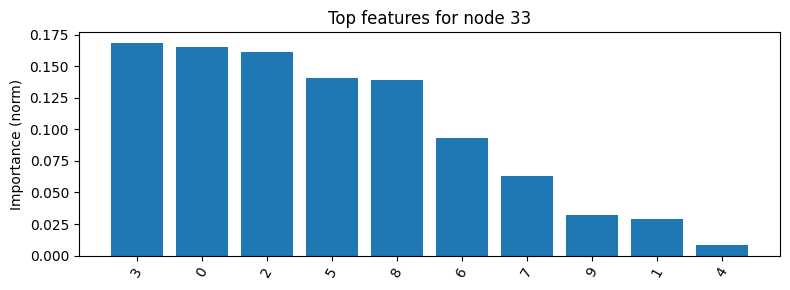

Saved explanation JSON: /content/drive/MyDrive/Bio_project/results_extension/explanation_node_33_robust.json
Done. If you want the official GNNExplainer visualization, tell me your torch_geometric.__version__


In [ ]:
# Robust node-level explanation (tries multiple APIs then gradient fallback)
import os, sys, numpy as np, torch, matplotlib.pyplot as plt

res_dir = "/content/drive/MyDrive/Bio_project/results_extension"  # adjust if needed
model_path = os.path.join(res_dir, "gnn_lineage_verified.pt")    # or your trained model
feat_path  = os.path.join(res_dir, "kg_node_features.npy")
edge_path  = os.path.join(res_dir, "kg_edge_index.npy")
y_path     = os.path.join(res_dir, "y_lineage_def_verified.npy")

# --- quick checks & load ---
print("torch:", torch.__version__)
try:
    import torch_geometric
    print("torch_geometric:", torch_geometric.__version__)
except Exception as e:
    print("torch_geometric not importable:", e)

x_np = np.load(feat_path)
edge_np = np.load(edge_path)
y_np = np.load(y_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor(x_np, dtype=torch.float, device=device)
edge_index = torch.tensor(edge_np, dtype=torch.long, device=device)

# --- Rebuild the model class you used (replace this with your exact class if different) ---
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
class LineageGNN(torch.nn.Module):
    def __init__(self, in_ch, hid_ch=128, out_ch=2, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.lin = torch.nn.Linear(hid_ch, out_ch)
        self.drop = dropout
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        return self.lin(x)

model = LineageGNN(x.shape[1]).to(device)
if os.path.exists(model_path):
    ck = torch.load(model_path, map_location=device)
    try:
        model.load_state_dict(ck)
    except Exception:
        # handle dictionary wrapper { "model_state": ... }
        if isinstance(ck, dict) and "model_state" in ck:
            model.load_state_dict(ck["model_state"])
        else:
            print("Warning: could not load state_dict cleanly; attempting partial load...")
            model.load_state_dict({k.replace("module.", ""):v for k,v in ck.items()}, strict=False)
model.eval()

# choose a target node index that is labeled lineage-def (1)
idxs = np.where(y_np == 1)[0]
if len(idxs) == 0:
    idx_target = 0
    print("No label==1 found: using node 0 as example")
else:
    idx_target = int(idxs[0])
print("Target node index:", idx_target)

# --- Try modern Explainer API (best effort) ---
expl_success = False
explanation = None
try:
    from torch_geometric.explain import Explainer, GNNExplainer
    print("Explainer classes imported; trying high-level Explainer API...")
    try:
        explainer = Explainer(
            model=model,
            algorithm=GNNExplainer(epochs=100),
            explanation_type='model',        # high-level; may differ by version
            node_mask_type='attributes',
            edge_mask_type='object',
            model_config=dict(mode='classification', task_level='node', return_type='raw')
        )
        explanation = explainer(x, edge_index, index=idx_target)  # some versions accept index=...
        expl_success = True
        print("Modern Explainer succeeded.")
    except Exception as e:
        print("Modern Explainer failed (continuing):", e)
except Exception as e:
    print("Modern Explainer import failed:", e)

# --- Try legacy GNNExplainer variants ---
if not expl_success:
    try:
        from torch_geometric.explain import GNNExplainer
        print("Trying legacy GNNExplainer instantiation...")
        # instantiate with minimal args to avoid API differences
        ge = GNNExplainer(model)            # many variants accept (model, epochs=...)
        # try several call signatures until one works
        tried = False
        for call in [
            lambda: ge.explain_node(idx_target, x, edge_index),
            lambda: ge.get_explanation_node(idx_target, x, edge_index),
            lambda: ge.explain_node(node_idx=idx_target, x=x, edge_index=edge_index),
            lambda: ge.get_explanation_node(node_idx=idx_target, x=x, edge_index=edge_index),
        ]:
            try:
                explanation = call()
                expl_success = True
                tried = True
                print("Legacy GNNExplainer variant succeeded.")
                break
            except Exception as e:
                # keep trying
                #print("variant failed:", e)
                continue
        if not tried:
            print("Tried legacy variants but method names differ in this build.")
    except Exception as e:
        print("Legacy GNNExplainer import/instantiation failed:", e)

# --- Gradient-based fallback (always works) ---
if not expl_success or explanation is None:
    print("Falling back to gradient-based feature importance (reliable fallback).")
    model.zero_grad()
    # require grads on input features
    x_req = x.clone().detach().requires_grad_(True)
    logits = model(x_req, edge_index)
    # choose class to explain (predicted class for node)
    pred_class = int(logits[idx_target].argmax().item())
    node_logit = logits[idx_target, pred_class]
    node_logit.backward(retain_graph=False)
    grads = x_req.grad.detach().cpu().numpy()    # shape (N, F)
    # feature importance for target node = abs(grad) for that node
    feat_imp = np.abs(grads[idx_target])
    # normalize
    feat_imp = feat_imp / (feat_imp.sum() + 1e-12)
    explanation = {"feature_importance": feat_imp, "edge_mask": None}
    expl_success = True
    print("Gradient fallback produced feature importance.")

# --- Extract and plot feature importances ---
if hasattr(explanation, "node_mask") or "node_mask" in explanation:
    # modern explanation object
    try:
        fm = explanation.node_mask.detach().cpu().ravel()
    except Exception:
        try:
            fm = explanation.feature_mask.detach().cpu().ravel()
        except Exception:
            fm = np.zeros(x.shape[1])
elif isinstance(explanation, dict) and "feature_importance" in explanation:
    fm = explanation["feature_importance"]
else:
    # try attribute access
    try:
        fm = np.array(explanation.feature_mask.detach().cpu())
    except Exception:
        fm = np.zeros(x.shape[1])

# plot top features
inds = np.argsort(-fm)[:30]
plt.figure(figsize=(8,3))
plt.bar(range(len(inds)), fm[inds])
plt.xticks(range(len(inds)), inds, rotation=60)
plt.ylabel("Importance (norm)")
plt.title(f"Top features for node {idx_target}")
plt.tight_layout()
plt.show()

# --- Save results ---
outp = {
    "node_idx": idx_target,
    "feature_importance": fm.tolist(),
    "top_features_idx": inds.tolist()
}
out_file = os.path.join(res_dir, f"explanation_node_{idx_target}_robust.json")
import json
with open(out_file, "w") as f:
    json.dump(outp, f, indent=2)
print("Saved explanation JSON:", out_file)

# Print final note
print("Done. If you want the official GNNExplainer visualization, tell me your torch_geometric.__version__")
